In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# Plot settings
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

RANDOM_STATE = 42

# Feature Selection & Other Methods Methods


## **Feature Selection Methods**

### **1. Low-Variance Filter**
**What it does**: Removes features with zero or near-zero variance  

### **2. High-Correlation Removal**
**What it does**: Removes one feature from highly correlated pairs (r > 0.95)   

In [2]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

def removing_high_and_low(df,feature_cols):
    var_selector = VarianceThreshold(threshold=0.0).fit(df[feature_cols])
    low_var_features = [f for f, keep in zip(feature_cols, var_selector.get_support()) if not keep]
    df_wo_low_var = df.drop(columns=low_var_features)
    features_wo_low_var = [f for f in feature_cols if f not in low_var_features]

    corr_matrix = df_wo_low_var[features_wo_low_var].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
    high_corr_features = [col for col in upper_tri.columns if (upper_tri[col] > 0.97).any()]

    df_filtered = df_wo_low_var.drop(columns=high_corr_features)
    selected_features = [f for f in features_wo_low_var if f not in high_corr_features]

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")

    print("Low-variance features:")
    display(low_var_features)
    print("Highly correlated features:")
    display(high_corr_features)
    print("Original feature count:", len(feature_cols))
    print("Remaining feature count:", len(selected_features))
    plt.show()
    return df_filtered, selected_features

#df_filtered,selected_features =removing_high_and_low(df,feature_cols)


### **3. Mutual Information (MI)**
**What it does**: Measures statistical dependency between features and flare classes    

In [3]:
from sklearn.feature_selection import mutual_info_classif

def Feature_MI_Choosing(df_filtered,selected_features,top_k):   
    a = df_filtered[selected_features]
    b = df_filtered['flare_numeric']

    mi_scores = mutual_info_classif(a, b, random_state=RANDOM_STATE)
    mi_series = pd.Series(mi_scores, index=selected_features).sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=mi_series[:top_k], y=mi_series.index[:top_k])
    plt.title("Top "+str(top_k)+" Features by Mutual Information")
    plt.xlabel("MI Score")
    plt.ylabel("Feature")
    selected_features_mi = mi_series.head(top_k).index.tolist()
    print("Top features by MI:")
    display(selected_features_mi)
    plt.show()
    df_filtered = df_filtered[selected_features_mi + ['flare_numeric']].copy()
    return df_filtered , selected_features_mi

#df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,20)

## **Other Methods**

### **6. PCA (Principal Component Analysis)**
**What it does**: Creates new orthogonal features that maximize variance  

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def perform_pca_analysis(df_filtered, selected_features, n_components=2):
    target_col='flare_numeric'
    a = df_filtered[selected_features]
    b = df_filtered[target_col]
    
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    pca_full = PCA()
    pca_full.fit(a_scaled)
    

    pca = PCA(n_components=n_components)
    a_pca = pca.fit_transform(a_scaled)
    
    pca_df = pd.DataFrame(a_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df[target_col] = b.values
    
    plt.figure(figsize=(15, 5))
    
   
    plt.subplot(1, 2, 1)
    if n_components >= 2:
        class_labels = df_filtered['flare_class4']
        scatter = plt.scatter(a_pca[:, 0], a_pca[:, 1], c=b, cmap='viridis', alpha=0.7)
        plt.title(f"PCA - First 2 Components")
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
        plt.colorbar(scatter, label='Flare Class (0=C, 1=M, 2=X)')
    else:
        plt.text(0.5, 0.5, "Need n_components >= 2\nfor 2D visualization", 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title("2D Visualization Not Available")
    
    plt.subplot(1, 2, 2)
    components_range = range(1, len(pca_full.explained_variance_ratio_) + 1)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(components_range, cumulative_variance, 'bo-', linewidth=2, markersize=6)
    plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% variance')
    plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Variance Explained')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Variance explained by first {n_components} components: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
    
    return pca_df, pca

# pca_df, pca_model = perform_pca_analysis(df_filtered=df, selected_features=feature_cols, n_components=9)


### **8. UMAP**
**What it does**: Non-linear projection preserving local and global structure   

In [8]:
from umap import umap_ as umap

def perform_umap_analysis(df_filtered, selected_features, target_col='flare_numeric', n_neighbors=15, min_dist=0.1):
    X = df_filtered[selected_features]
    y = df_filtered[target_col]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=RANDOM_STATE)
    X_umap = reducer.fit_transform(X_scaled)
    
    umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
    umap_df[target_col] = y.values
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="Set2")
    plt.title(f"UMAP Visualization (n_neighbors={n_neighbors})")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Flare Class")
    plt.show()
    
    print(f"UMAP completed on {len(X_scaled)} samples")
    return umap_df, reducer


#umap_df, umap_model = perform_umap_analysis(df_filtered=df,selected_features=feature_cols,n_neighbors=15,min_dist=0.1)

### **9.SMOTE**

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def apply_smote_balancing(df_filtered, selected_features, target_col='flare_numeric', k_neighbors=5, random_state=42,sampling_strat='auto'):
    X = df_filtered[selected_features]
    y = df_filtered[target_col]
    
    original_dist = Counter(y)
    
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k_neighbors, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    new_dist = Counter(y_resampled)
    

    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    classes = list(original_dist.keys())
    counts_before = list(original_dist.values())
    bars_before = plt.bar(classes, counts_before, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Class Distribution - Before SMOTE')
    plt.xlabel('Flare Class')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    for bar, count in zip(bars_before, counts_before):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(counts_before), 
                f'{count}', ha='center', va='bottom')
    
    plt.subplot(2, 2, 2)
    counts_after = [new_dist[cls] for cls in classes]
    bars_after = plt.bar(classes, counts_after, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Class Distribution - After SMOTE')
    plt.xlabel('Flare Class')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    for bar, count in zip(bars_after, counts_after):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(counts_after), 
                f'{count}', ha='center', va='bottom')
    
    plt.subplot(2, 2, 3)
    pca = PCA(n_components=2)
    X_pca_before = pca.fit_transform(X)
    
    for class_id in np.unique(y):
        mask = y == class_id
        plt.scatter(X_pca_before[mask, 0], X_pca_before[mask, 1], 
                   label=f'Class {class_id}', alpha=0.7, s=20)
    plt.title('Clustering - Before SMOTE (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    X_pca_after = pca.transform(X_resampled)
    
    for class_id in np.unique(y_resampled):
        mask = y_resampled == class_id
        plt.scatter(X_pca_after[mask, 0], X_pca_after[mask, 1], 
                   label=f'Class {class_id}', alpha=0.7, s=20)
    plt.title('Clustering - After SMOTE (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    
    plt.show()
    
    print(f"\nTotal samples increased from {len(X)} to {len(X_resampled)}")
    
    return X_resampled, y_resampled, smote


# X_balanced, y_balanced, smote_model = apply_smote_balancing(df_filtered=df, selected_features=feature_cols,target_col='flare_numeric',k_neighbors=5,random_state=RANDOM_STATE)


### **10.Combining Datasets**

In [10]:
from sklearn.model_selection import train_test_split

def preparing_dataset(train_path, val_path, test_path, test_size=0.2, val_size=0.1, random_state=42):  
    df_train = pd.read_csv(train_path)
    df_val = pd.read_csv(val_path) 
    df_test = pd.read_csv(test_path)
    
    print("\nORIGINAL DATASET COUNTS:")
    print(f"Training samples: {len(df_train)}")
    print(f"Validation samples: {len(df_val)}")
    print(f"Test samples: {len(df_test)}")
    total_original = len(df_train) + len(df_val) + len(df_test)
    print(f"Total original: {total_original}")
    
    df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)
    print(f"\nCombined dataset shape: {df_combined.shape}")

    df_temp, df_test_new = train_test_split(df_combined, test_size=test_size, random_state=random_state)
    
    df_train_new, df_val_new = train_test_split(df_temp,test_size=val_size,random_state=random_state)
    
    print("\nNEW SPLIT COUNTS:")
    print(f"Training samples: {len(df_train_new)} ({len(df_train_new)/len(df_combined):.1%})")
    print(f"Validation samples: {len(df_val_new)} ({len(df_val_new)/len(df_combined):.1%})")
    print(f"Test samples: {len(df_test_new)} ({len(df_test_new)/len(df_combined):.1%})")
    
    return df_train_new, df_val_new, df_test_new

#train_df, val_df, test_df = preparing_dataset(train_path='Train_Data_by_AR.csv',val_path='Validation_Data_by_AR.csv', test_path='Test_Data_by_AR.csv', test_size=0.1,val_size=0.1,random_state=RANDOM_STATE)


#print(f"\nReturned DataFrames:")
#print(f"train_df shape: {train_df.shape}")
#print(f"val_df shape: {val_df.shape}")
#print(f"test_df shape: {test_df.shape}")

### **11.Cobmining rare classes**

In [11]:
from sklearn.model_selection import train_test_split
import pandas as pd

def dataset_rare_classes_maximized(train_path, val_path, test_path, test_size=0.2, val_size=0.1, random_state=42):
    df_train = pd.read_csv(train_path)
    df_val = pd.read_csv(val_path) 
    df_test = pd.read_csv(test_path)
    
    print("\nORIGINAL DATASET COUNTS:")
    print(f"Training samples: {len(df_train)}")
    print(f"Validation samples: {len(df_val)}")
    print(f"Test samples: {len(df_test)}")
    total_original = len(df_train) + len(df_val) + len(df_test)
    print(f"Total original: {total_original}")
    
    df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)
    print(f"\nCombined dataset shape: {df_combined.shape}")
    
    # Simplifying the classes
    df_combined['flare_class4'] = df_combined['flare_strength'].apply(map_flare_class)

    # Switching the flare class into a numeric value
    df_combined['flare_numeric'] = df_combined['flare_class4'].apply(flare_to_num)
    
    # Separate rare classes (1, 2, 3) from common classes (0)
    rare_classes_mask = df_combined['flare_numeric'].isin([1, 2, 3])
    df_rare = df_combined[rare_classes_mask]
    df_common = df_combined[~rare_classes_mask]  # Class 0 only
    
    # Split common class (0) into train/test
    df_common_temp, df_test_new = train_test_split(
        df_common, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df_common['flare_numeric']
    )
    
    # Split remaining common class into train/validation
    df_train_new, df_val_common = train_test_split(
        df_common_temp,
        test_size=val_size,
        random_state=random_state,
        stratify=df_common_temp['flare_numeric']
    )
    
    # **FIXED: Get exactly 30,000 samples of class 1 + all classes 2 and 3**
    class_1_data = df_rare[df_rare['flare_numeric'] == 1]
    classes_2_3_data = df_rare[df_rare['flare_numeric'].isin([2, 3])]
    
    # Sample exactly 30,000 from class 1 (or all available if less)
    n_class_1_target = 30000
    if len(class_1_data) >= n_class_1_target:
        class_1_sampled = class_1_data.sample(n=n_class_1_target, random_state=random_state)
    else:
        class_1_sampled = class_1_data
        print(f"⚠️ Only {len(class_1_data)} class 1 samples available (wanted {n_class_1_target})")
    
    # Combine: validation common (class 0) + 30,000 class 1 + all classes 2 and 3
    df_val_new = pd.concat([df_val_common, class_1_sampled, classes_2_3_data], ignore_index=True)
    
    # Print final distribution
    print("\nFINAL DATASET COUNTS:")
    print(f"Training samples: {len(df_train_new)}")
    print(f"Validation samples: {len(df_val_new)}")
    print(f"Test samples: {len(df_test_new)}")
    
    print("\nVALIDATION SET CLASS DISTRIBUTION:")
    val_dist = df_val_new['flare_numeric'].value_counts().sort_index()
    for class_id, count in val_dist.items():
        print(f"  Class {class_id}: {count} samples")
    
    return df_train_new, df_val_new, df_test_new

# Loading and Visualizing the Data

In [12]:
train_path='Train_Data_by_AR.csv'
val_path= 'Validation_Data_by_AR.csv'
test_path='Test_Data_by_AR.csv'

In [13]:
df_train , df_val, df_test = preparing_dataset(train_path,val_path, test_path, test_size=0.1, val_size=0.1, random_state=RANDOM_STATE)


ORIGINAL DATASET COUNTS:
Training samples: 759357
Validation samples: 95933
Test samples: 94757
Total original: 950047

Combined dataset shape: (950047, 32)

NEW SPLIT COUNTS:
Training samples: 769537 (81.0%)
Validation samples: 85505 (9.0%)
Test samples: 95005 (10.0%)


In [14]:
# I will use the df_Test as the main dataset for computational reasons
df=df_test

print("Shape:", df.shape)
print("Columns:")
display(df.columns.tolist())

Shape: (95005, 32)
Columns:


['grad_mean',
 'grad_std',
 'grad_median',
 'grad_min',
 'grad_max',
 'grad_skewness',
 'grad_kurtosis',
 'nl_length',
 'nl_num_fragments',
 'nl_grad_weighted_length',
 'nl_curv_mean',
 'nl_curv_std',
 'nl_curv_median',
 'nl_curv_min',
 'nl_curv_max',
 'nl_bend_energy_mean',
 'nl_bend_energy_std',
 'nl_bend_energy_median',
 'nl_bend_energy_min',
 'nl_bend_energy_max',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_unsigned',
 'flux_signed',
 'flux_negative',
 'flux_positive',
 'class_label',
 'flare_strength',
 'image_path']

In [15]:
missing_cols = df.isna().any().sum()
complete_cols = len(df.columns) -missing_cols

print("Number of columns with missing values:", missing_cols)
print("Number of columns with complete values:", complete_cols)

print("Basic statistics for numeric columns:")
display(df.describe().T)

Number of columns with missing values: 0
Number of columns with complete values: 32
Basic statistics for numeric columns:


count      mean       std       min           25%  \
grad_mean                95005.0  0.173714  0.085747  0.005662  1.131666e-01   
grad_std                 95005.0  0.212768  0.080490  0.017851  1.537657e-01   
grad_median              95005.0  0.083492  0.032264  0.003671  6.931276e-02   
grad_min                 95005.0  0.035588  0.092838  0.000000  4.350000e-16   
grad_max                 95005.0  0.079847  0.059806  0.008429  5.524328e-02   
grad_skewness            95005.0  0.047793  0.042024  0.000401  3.022159e-02   
grad_kurtosis            95005.0  0.005393  0.019602  0.000016  1.568042e-03   
nl_length                95005.0  0.005634  0.008360  0.000000  2.492627e-03   
nl_num_fragments         95005.0  0.008178  0.018084  0.000000  2.757480e-03   
nl_grad_weighted_length  95005.0  0.369804  0.076609  0.013279  3.185354e-01   
nl_curv_mean             95005.0  0.268146  0.046482  0.002163  2.424823e-01   
nl_curv_std              95005.0  0.472996  0.064825  0.023774  4.379854e-01   
nl_curv_median           95005.0  0.565086  0.495471  0.000000  0.000000e+00   
nl_curv_min              95005.0  0.662457  0.305579  0.000000  4.084080e-01   
nl_curv_max              95005.0  0.000000  0.000000  0.000000  0.000000e+00   
nl_bend_energy_mean      95005.0  0.519458  0.093368  0.018770  4.608923e-01   
nl_bend_energy_std       95005.0  0.398971  0.086450  0.064951  3.404893e-01   
nl_bend_energy_median    95005.0  0.593730  0.092543  0.074513  5.397439e-01   
nl_bend_energy_min       95005.0  0.000000  0.000000  0.000000  0.000000e+00   
nl_bend_energy_max       95005.0  0.235783  0.096497  0.021385  1.584578e-01   
wavelet_energy_1         95005.0  0.118598  0.053650  0.001998  8.152475e-02   
wavelet_energy_2         95005.0  0.175335  0.086168  0.006808  1.143061e-01   
wavelet_energy_3         95005.0  0.164625  0.087689  0.014193  1.026699e-01   
wavelet_energy_4         95005.0  0.153711  0.091394  0.000005  8.923470e-02   
wavelet_energy_5         95005.0  0.151822  0.093330  0.000948  8.631695e-02   
flux_unsigned            95005.0  0.095655  0.069852  0.000000  4.900799e-02   
flux_signed              95005.0  0.890228  0.077706  0.001864  8.611424e-01   
flux_negative            95005.0  0.482353  0.070965  0.001191  4.510649e-01   
flux_positive            95005.0  0.094837  0.069660  0.000147  4.886078e-02   
class_label              95005.0  0.201105  0.400829  0.000000  0.000000e+00   

                                  50%           75%       max  
grad_mean                1.560251e-01  2.142056e-01  0.998969  
grad_std                 2.038649e-01  2.604510e-01  0.980747  
grad_median              8.067734e-02  9.330169e-02  0.955468  
grad_min                 1.380000e-15  3.480000e-15  0.620174  
grad_max                 6.647936e-02  8.087665e-02  0.941660  
grad_skewness            4.022136e-02  5.373481e-02  0.856668  
grad_kurtosis            2.427650e-03  3.898975e-03  0.852521  
nl_length                4.037354e-03  6.178907e-03  0.249544  
nl_num_fragments         4.687715e-03  7.445195e-03  0.503378  
nl_grad_weighted_length  3.764059e-01  4.266957e-01  0.719293  
nl_curv_mean             2.802750e-01  3.012269e-01  0.879316  
nl_curv_std              4.887360e-01  5.189781e-01  0.922391  
nl_curv_median           1.000000e+00  1.000000e+00  1.000000  
nl_curv_min              6.895492e-01  1.000000e+00  1.000000  
nl_curv_max              0.000000e+00  0.000000e+00  0.000000  
nl_bend_energy_mean      5.216752e-01  5.812445e-01  0.974767  
nl_bend_energy_std       3.975569e-01  4.553912e-01  0.943482  
nl_bend_energy_median    6.002155e-01  6.565474e-01  0.940405  
nl_bend_energy_min       0.000000e+00  0.000000e+00  0.000000  
nl_bend_energy_max       2.372032e-01  2.895709e-01  1.000000  
wavelet_energy_1         1.083764e-01  1.442839e-01  0.642423  
wavelet_energy_2         1.577247e-01  2.162536e-01  0.998814  
wavelet_energy_3         1.468813e-01  2.058860e-01  0.982903  
wavelet_en

In [16]:
all_columns = df.columns.tolist()

non_feature_cols = ["class_label", "flare_strength", "image_path"]

feature_cols = [c for c in all_columns if c not in non_feature_cols]

print("Number of feature columns:", len(feature_cols))
print("Feature columns:")
print(feature_cols)

print("\nNon-feature columns:")
print(non_feature_cols)

Number of feature columns: 29
Feature columns:
['grad_mean', 'grad_std', 'grad_median', 'grad_min', 'grad_max', 'grad_skewness', 'grad_kurtosis', 'nl_length', 'nl_num_fragments', 'nl_grad_weighted_length', 'nl_curv_mean', 'nl_curv_std', 'nl_curv_median', 'nl_curv_min', 'nl_curv_max', 'nl_bend_energy_mean', 'nl_bend_energy_std', 'nl_bend_energy_median', 'nl_bend_energy_min', 'nl_bend_energy_max', 'wavelet_energy_1', 'wavelet_energy_2', 'wavelet_energy_3', 'wavelet_energy_4', 'wavelet_energy_5', 'flux_unsigned', 'flux_signed', 'flux_negative', 'flux_positive']

Non-feature columns:
['class_label', 'flare_strength', 'image_path']


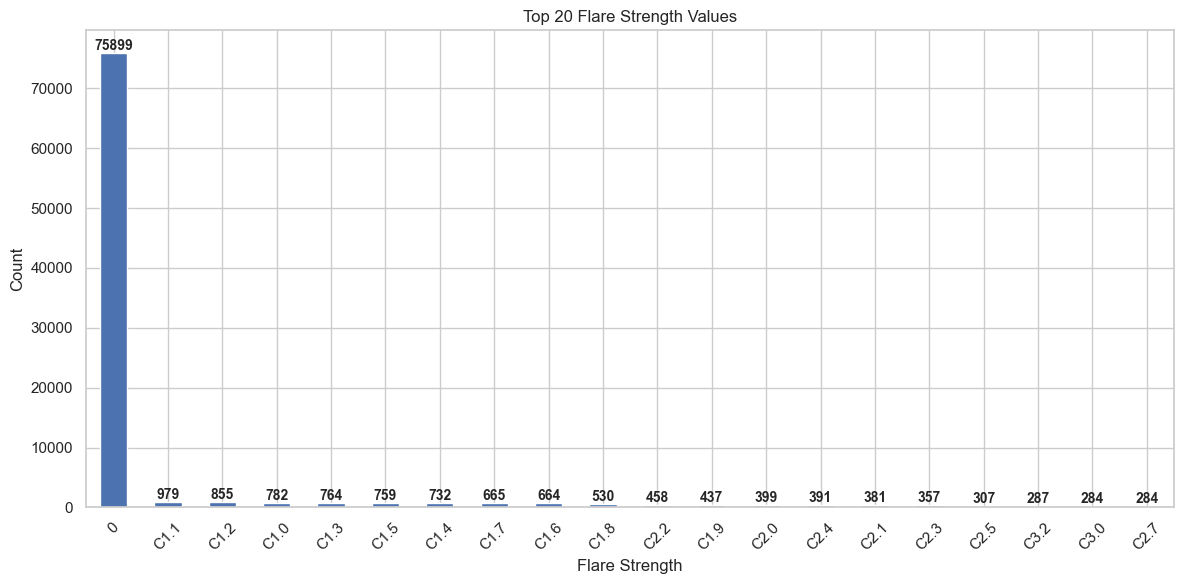

In [17]:
plt.figure(figsize=(12, 6))
ax = df["flare_strength"].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Flare Strength Values")
plt.xlabel("Flare Strength")
plt.ylabel("Count")
plt.xticks(rotation=45)
for i, v in enumerate(df["flare_strength"].value_counts().head(20)):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


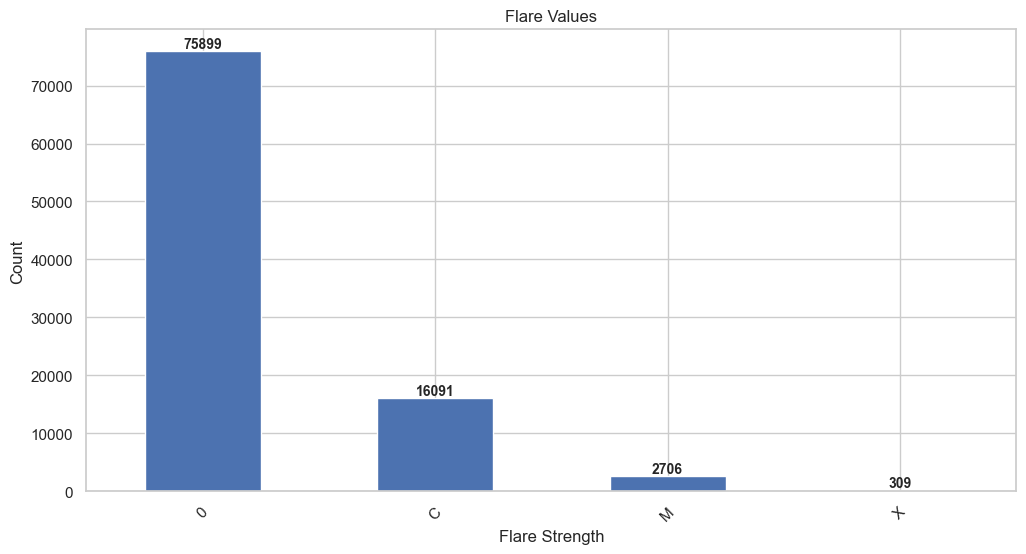


flare_class4 ratios:
  0: 75899 (79.889%)
  C: 16091 (16.937%)
  M: 2706 (2.848%)
  X: 309 (0.325%)


In [18]:
def map_flare_class(fs):
    if fs == 0 or str(fs) == "0":
        return "0"
    s = str(fs)
    if s.startswith("C"):
        return "C"
    if s.startswith("M"):
        return "M"
    if s.startswith("X"):
        return "X"
    return "other"

def flare_to_num(s):
    s = str(s)
    if s == '0':
        return 0
    elif s.startswith('C'):
        return 1
    elif s.startswith('M'):
        return 2
    elif s.startswith('X'):
        return 3
    else:
        return np.nan

def print_class_ratios(series, name=""):
    counts = series.value_counts()
    total = len(series)
    print(f"\n{name} ratios:")
    for c, v in counts.items():
        print(f"  {c}: {v} ({v / total:.3%})")

#simplifiying the classes
df['flare_class4']=df['flare_strength'].apply(map_flare_class)

#Switching the flare class into a numeric value
df['flare_numeric']=df['flare_class4'].apply(flare_to_num)

non_feature_cols.append('flare_class4')
non_feature_cols.append('flare_numeric')

plt.figure(figsize=(12, 6))
ax = df["flare_class4"].value_counts().plot(kind='bar')
plt.title("Flare Values")
plt.xlabel("Flare Strength")
plt.ylabel("Count")
plt.xticks(rotation=45)
for i, v in enumerate(df["flare_class4"].value_counts().head(20)):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

print_class_ratios(df["flare_class4"],"flare_class4")

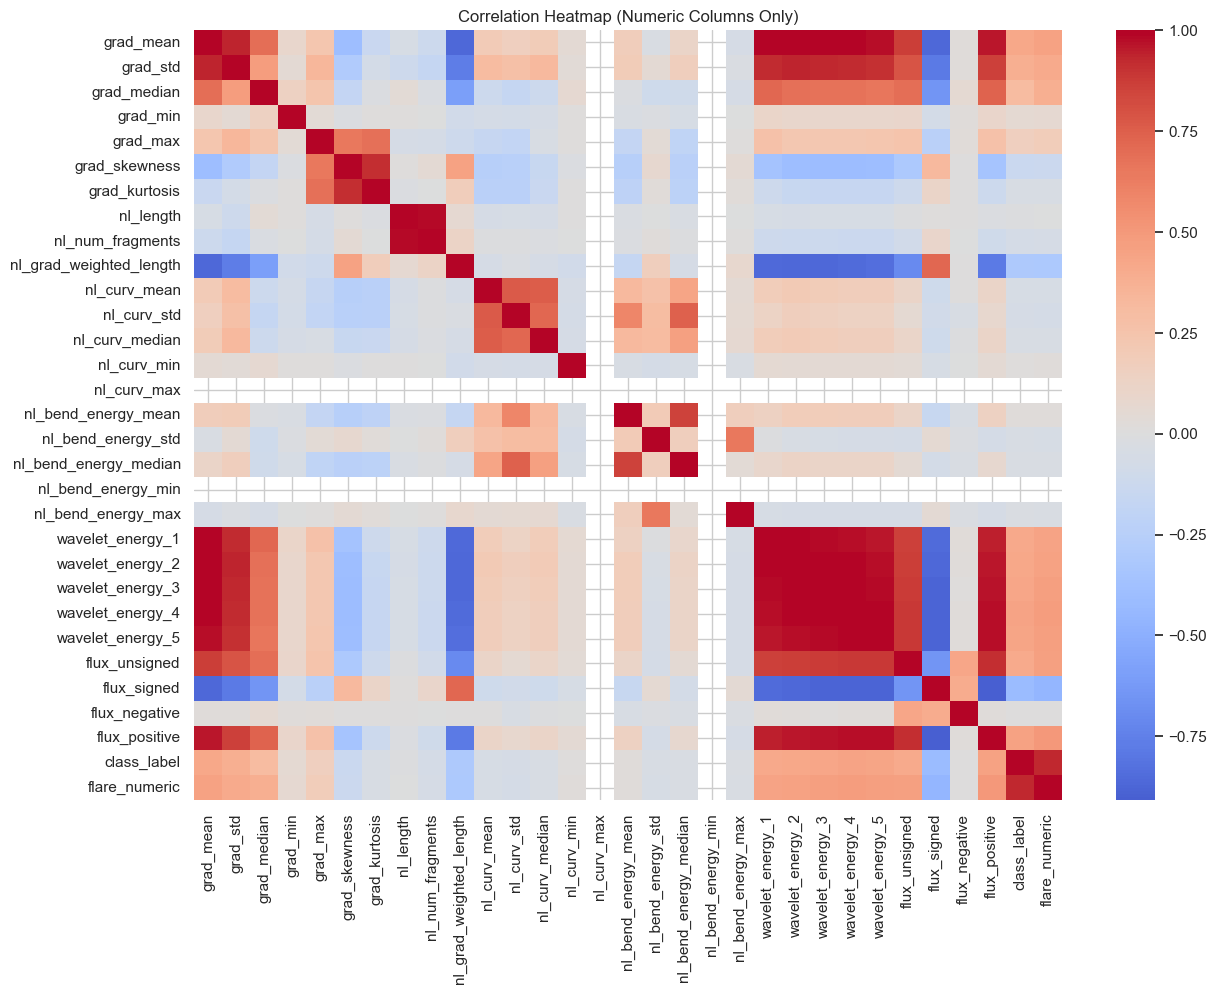

In [19]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_4524\1233233017.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corrs.values, y=corrs.index, palette='coolwarm')


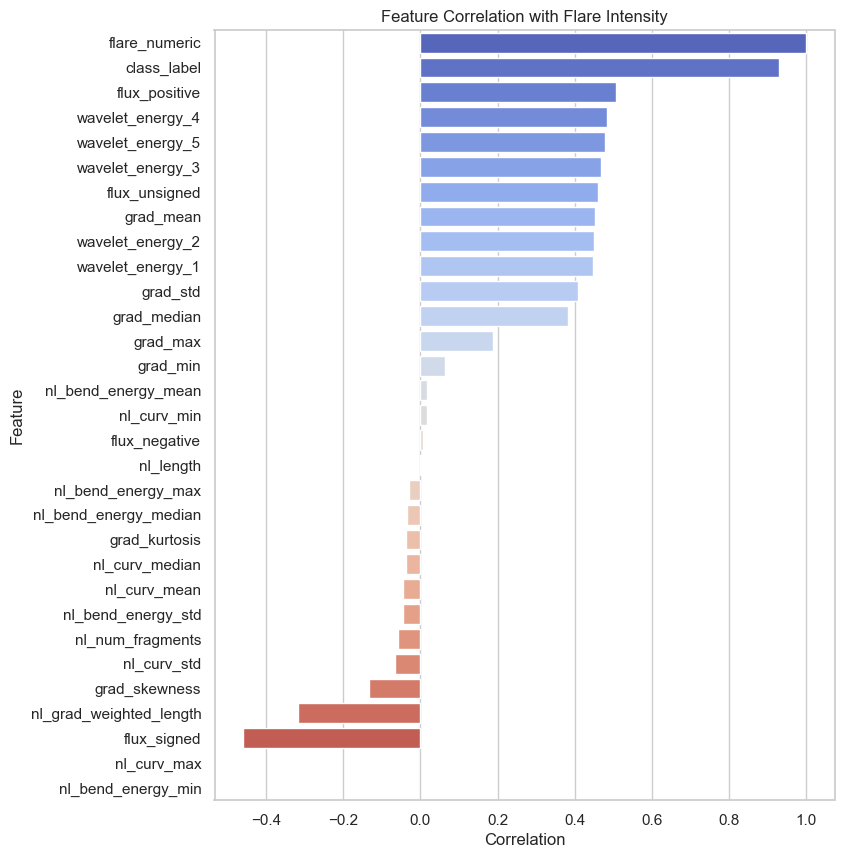

In [20]:
# polting the correlation with the numeric value of flare strength

corrs = numeric_df.corr()['flare_numeric'].sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x=corrs.values, y=corrs.index, palette='coolwarm')
plt.title("Feature Correlation with Flare Intensity")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

# Model 1


In [22]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Preproccessing

Low-variance features:


['nl_curv_max', 'nl_bend_energy_min']

Highly correlated features:


['nl_num_fragments',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 20


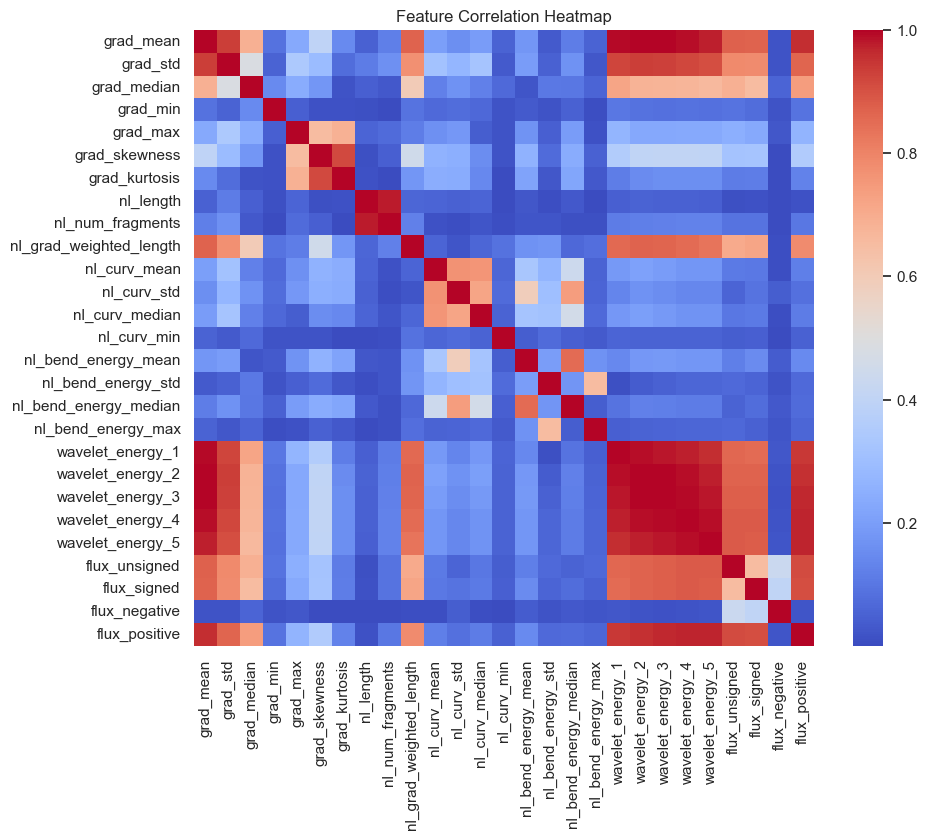

In [23]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_signed',
 'grad_mean',
 'wavelet_energy_2',
 'wavelet_energy_1',
 'flux_unsigned',
 'grad_std',
 'grad_median',
 'grad_skewness',
 'grad_max',
 'grad_kurtosis',
 'nl_grad_weighted_length',
 'nl_length',
 'flux_negative']

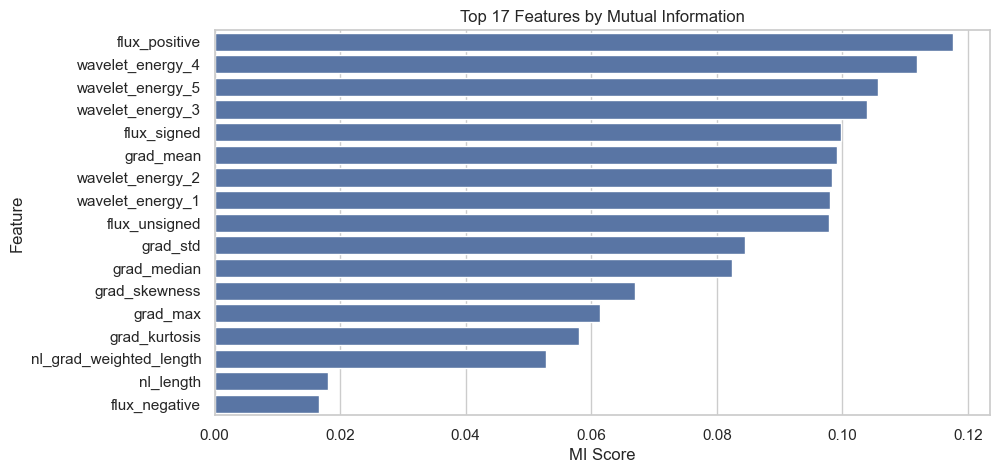

(95005, 18)

In [24]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


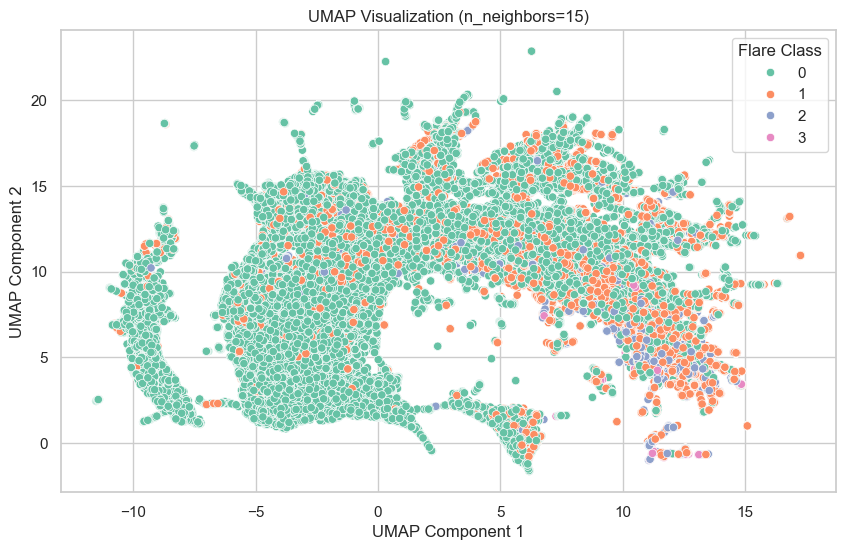

UMAP completed on 95005 samples


In [29]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [30]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [31]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train1=scaler.fit_transform(training_df[selected_features])
Y_train1=training_df['flare_numeric']

X_val1 = scaler.transform(validating_df[selected_features])
y_val1 = validating_df['flare_numeric']

X_test1 = scaler.transform(testing_df[selected_features])
y_test1 = testing_df['flare_numeric']

print("Training samples:", len(X_train1))
print("Validation samples:",len(X_val1))
print("Test samples:",len(X_test1))
print("Total samples:", str(len(X_train1) + len(X_val1) + len(X_test1)))

Training samples: 57003
Validation samples: 19001
Test samples: 19001
Total samples: 95005


## Training

In [32]:
from sklearn.svm import SVC
svm_model1=SVC(kernel='rbf', random_state=42)

svm_model1.fit(X_train1, Y_train1)

y_train_pred1 = svm_model1.predict(X_train1)
y_test_pred1 = svm_model1.predict(X_test1)

In [33]:
train_accuracy_1 = accuracy_score(Y_train1, y_train_pred1)
test_accuracy_1 = accuracy_score(y_test1, y_test_pred1)
test_precision_1 = precision_score(y_test1, y_test_pred1, average='weighted', zero_division=0)
test_recall_1 = recall_score(y_test1, y_test_pred1, average='weighted', zero_division=0)
test_f1_1 = f1_score(y_test1, y_test_pred1, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_1:.4f} ({train_accuracy_1*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_1:.4f} ({test_accuracy_1*100:.2f}%)")
print(f"PRECISION:         {test_precision_1:.4f}")
print(f"RECALL:            {test_recall_1:.4f}")
print(f"F1-SCORE:          {test_f1_1:.4f}")

TRAINING ACCURACY: 0.8262 (82.62%)
TEST ACCURACY:     0.8242 (82.42%)
PRECISION:         0.7963
RECALL:            0.8242
F1-SCORE:          0.7802


In [34]:
print(classification_report(y_test1, y_test_pred1, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.84      0.99      0.91     15180
     C-Class       0.58      0.20      0.30      3218
     M-Class       0.88      0.10      0.19       541
     X-Class       0.88      0.11      0.20        62

    accuracy                           0.82     19001
   macro avg       0.79      0.35      0.40     19001
weighted avg       0.80      0.82      0.78     19001



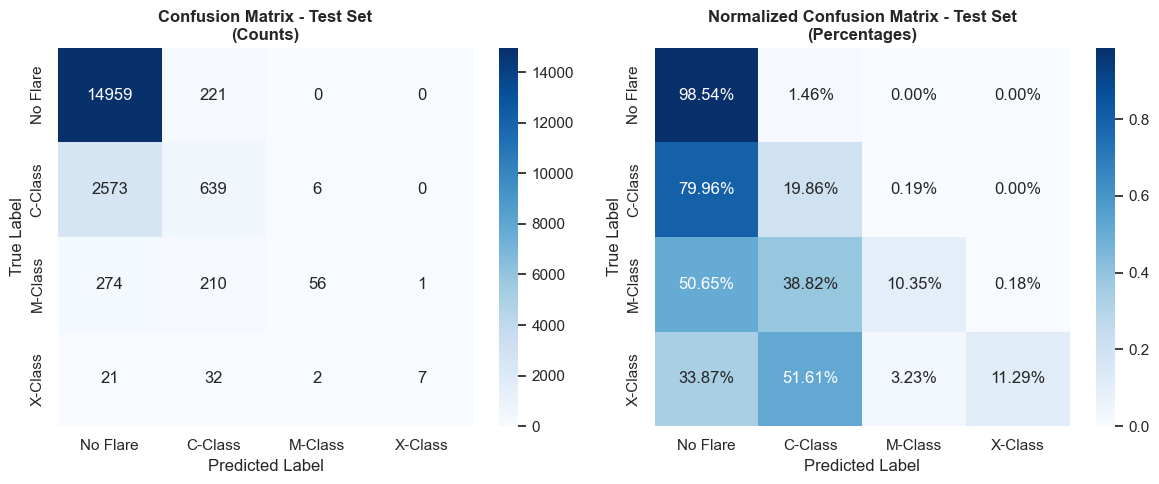

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test1, y_test_pred1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 2
Smote self made sampling strat

In [36]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Preproccessing

Low-variance features:


['nl_curv_max', 'nl_bend_energy_min']

Highly correlated features:


['nl_num_fragments',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 20


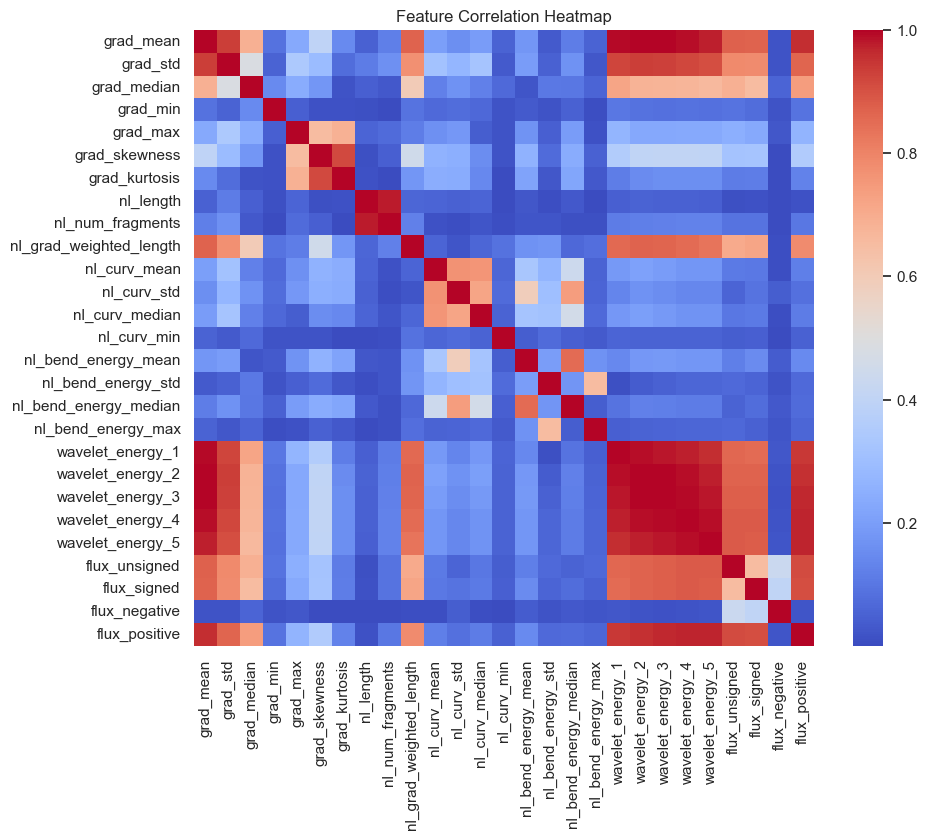

In [37]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_signed',
 'grad_mean',
 'wavelet_energy_2',
 'wavelet_energy_1',
 'flux_unsigned',
 'grad_std',
 'grad_median',
 'grad_skewness',
 'grad_max',
 'grad_kurtosis',
 'nl_grad_weighted_length',
 'nl_length',
 'flux_negative']

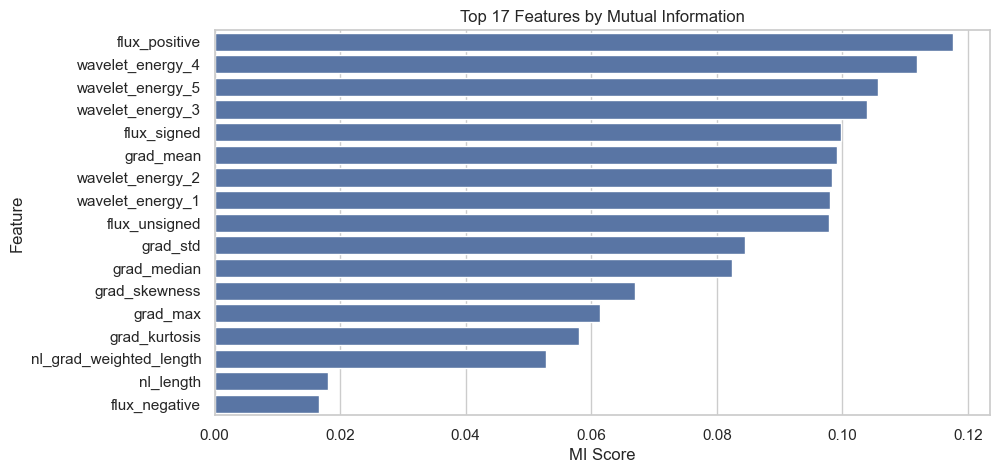

(95005, 18)

In [38]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


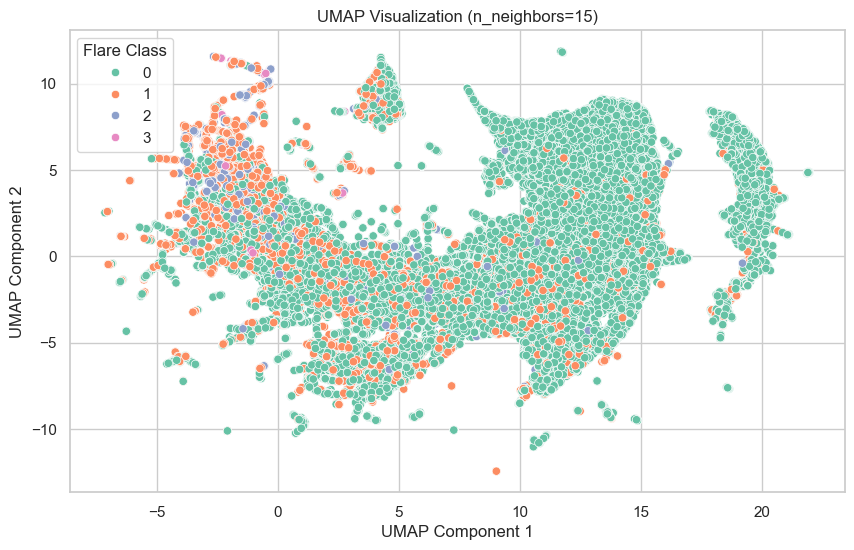

UMAP completed on 95005 samples


In [39]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [40]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [41]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train2=scaler.fit_transform(training_df[selected_features])
Y_train2=training_df['flare_numeric']

X_val2 = scaler.transform(validating_df[selected_features])
y_val2 = validating_df['flare_numeric']

X_test2 = scaler.transform(testing_df[selected_features])
y_test2 = testing_df['flare_numeric']

print("Training samples:", len(X_train2))
print("Validation samples:",len(X_val2))
print("Test samples:",len(X_test2))
print("Total samples:", str(len(X_train2) + len(X_val2) + len(X_test2)))

Training samples: 57003
Validation samples: 19001
Test samples: 19001
Total samples: 95005


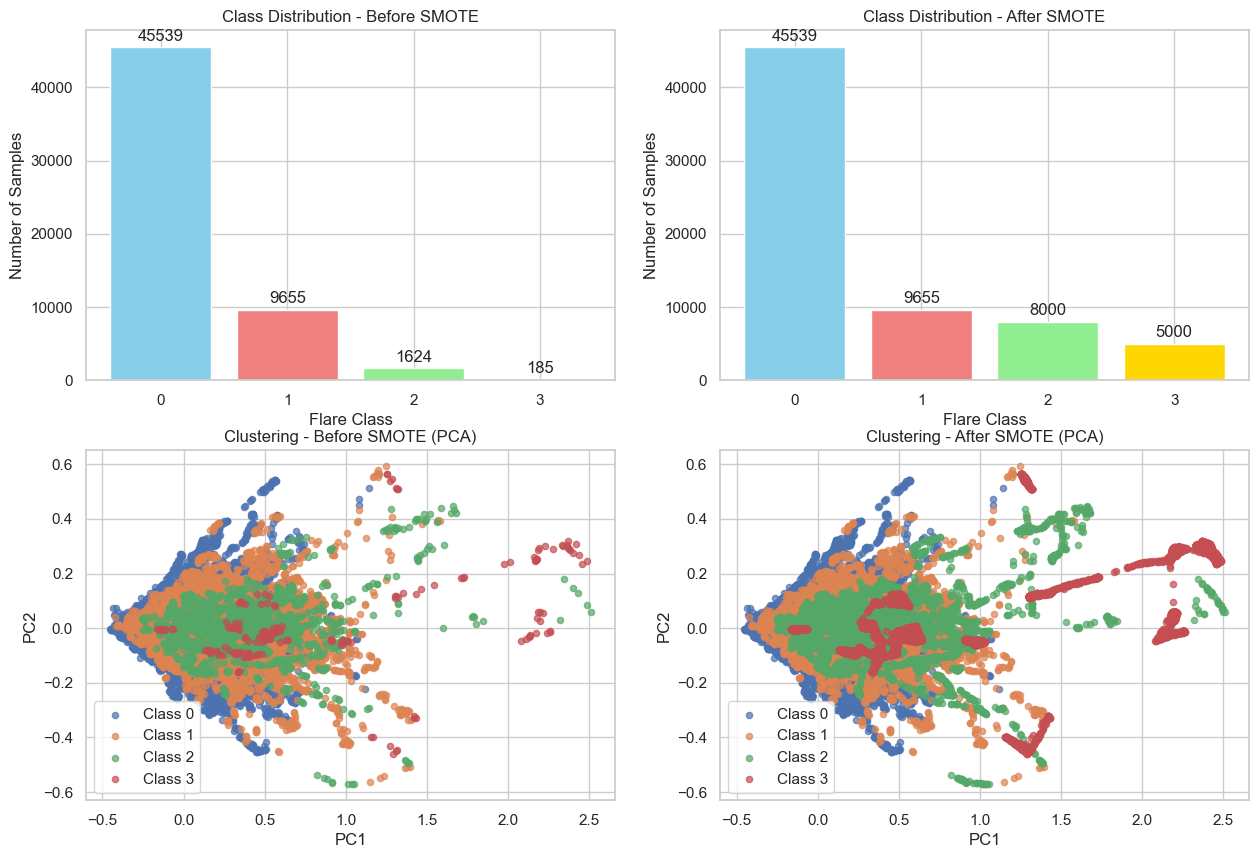


Total samples increased from 57003 to 68194


In [50]:
ss={2:8000, 3:5000}
X_train2, Y_train2, smote_model = apply_smote_balancing(df_filtered=training_df, selected_features=selected_features,target_col='flare_numeric',k_neighbors=5,random_state=RANDOM_STATE,sampling_strat=ss)

## Training

In [51]:
from sklearn.svm import SVC
svm_model2=SVC(kernel='rbf', random_state=42)

svm_model2.fit(X_train2, Y_train2)

y_train_pred2 = svm_model2.predict(X_train2)
y_test_pred2 = svm_model2.predict(X_test2)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [44]:
train_accuracy_2 = accuracy_score(Y_train2, y_train_pred2)
test_accuracy_2 = accuracy_score(y_test2, y_test_pred2)
test_precision_2 = precision_score(y_test2, y_test_pred2, average='weighted', zero_division=0)
test_recall_2 = recall_score(y_test2, y_test_pred2, average='weighted', zero_division=0)
test_f1_2 = f1_score(y_test2, y_test_pred2, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_2:.4f} ({train_accuracy_2*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_2:.4f} ({test_accuracy_2*100:.2f}%)")
print(f"PRECISION:         {test_precision_2:.4f}")
print(f"RECALL:            {test_recall_2:.4f}")
print(f"F1-SCORE:          {test_f1_2:.4f}")

TRAINING ACCURACY: 0.7554 (75.54%)
TEST ACCURACY:     0.7974 (79.74%)
PRECISION:         0.7009
RECALL:            0.7974
F1-SCORE:          0.7120


In [45]:
print(classification_report(y_test2, y_test_pred2, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.80      1.00      0.89     15180
     C-Class       0.36      0.01      0.02      3218
     M-Class       0.00      0.00      0.00       541
     X-Class       0.00      0.00      0.00        62

    accuracy                           0.80     19001
   macro avg       0.29      0.25      0.23     19001
weighted avg       0.70      0.80      0.71     19001



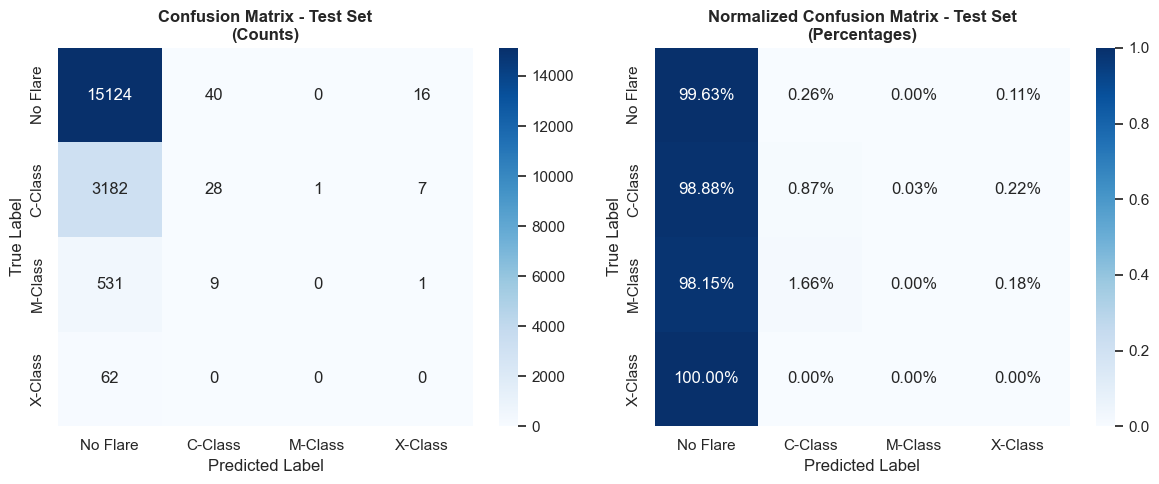

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test2, y_test_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 3
Smote "auto"

In [21]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Preproccessing

Low-variance features:


['nl_curv_max', 'nl_bend_energy_min']

Highly correlated features:


['nl_num_fragments',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 20


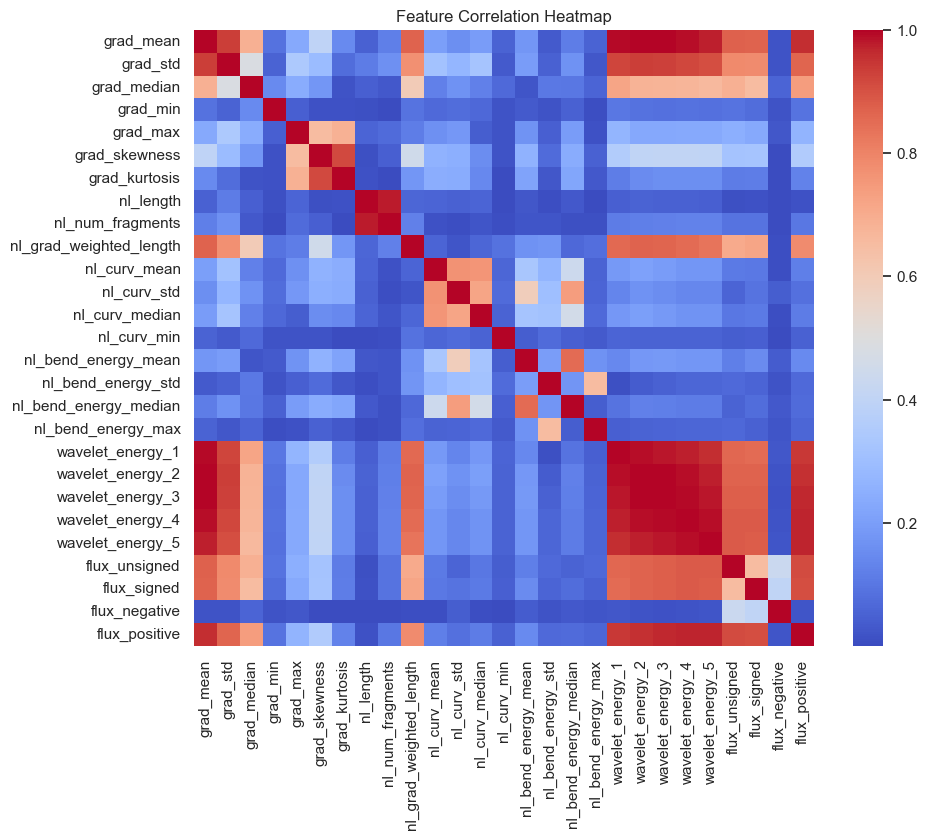

In [22]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_signed',
 'grad_mean',
 'wavelet_energy_2',
 'wavelet_energy_1',
 'flux_unsigned',
 'grad_std',
 'grad_median',
 'grad_skewness',
 'grad_max',
 'grad_kurtosis',
 'nl_grad_weighted_length',
 'nl_length',
 'flux_negative']

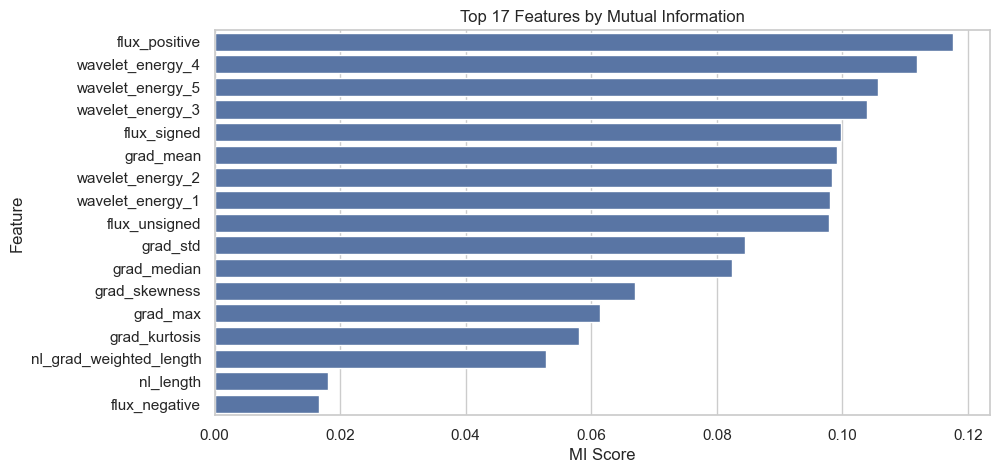

(95005, 18)

In [23]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


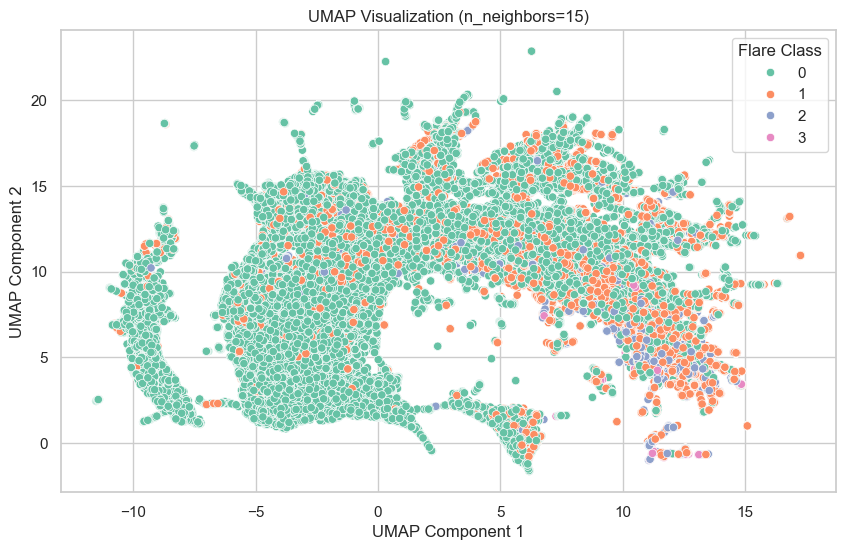

UMAP completed on 95005 samples


In [24]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [25]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [26]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train3=scaler.fit_transform(training_df[selected_features])
Y_train3=training_df['flare_numeric']

X_val3 = scaler.transform(validating_df[selected_features])
y_val3 = validating_df['flare_numeric']

X_test3 = scaler.transform(testing_df[selected_features])
y_test3 = testing_df['flare_numeric']

print("Training samples:", len(X_train3))
print("Validation samples:",len(X_val3))
print("Test samples:",len(X_test3))
print("Total samples:", str(len(X_train3) + len(X_val3) + len(X_test3)))

Training samples: 57003
Validation samples: 19001
Test samples: 19001
Total samples: 95005


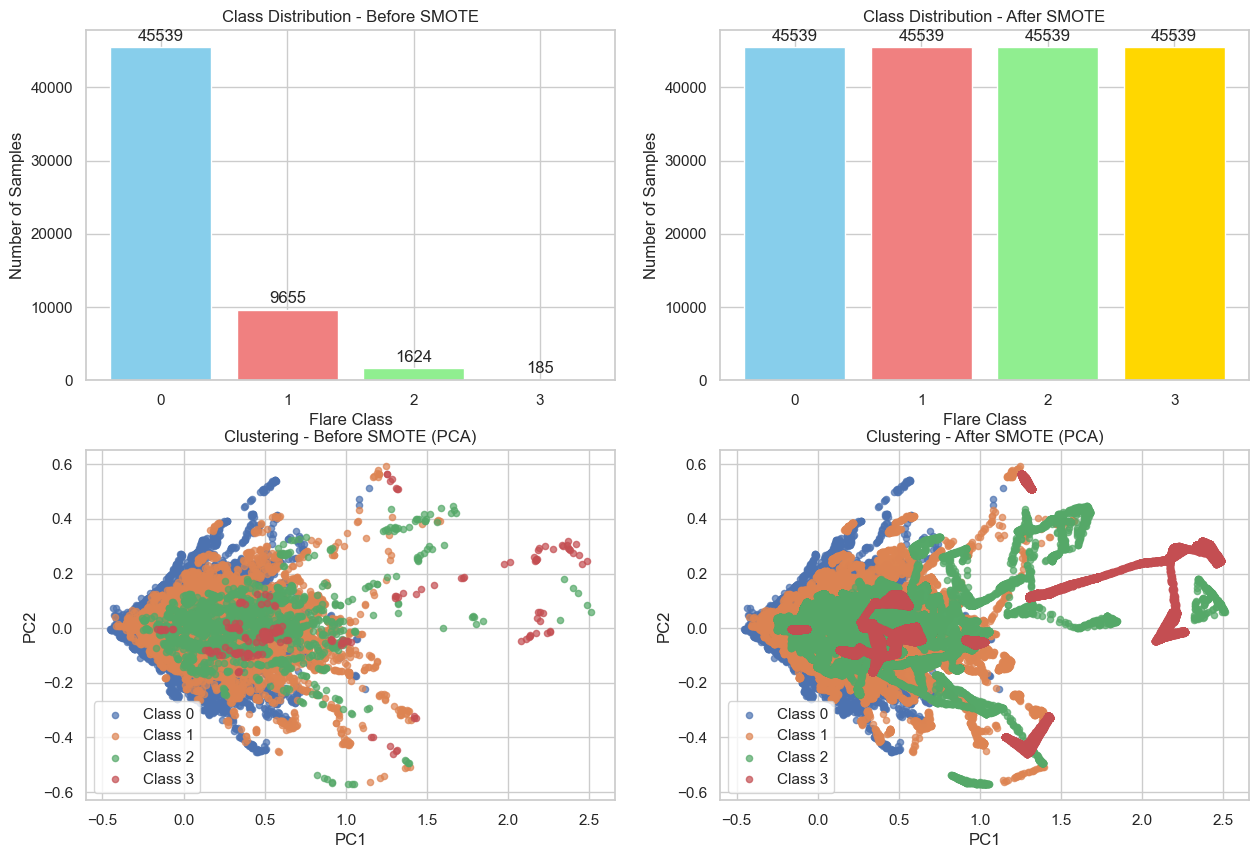


Total samples increased from 57003 to 182156


In [27]:
X_train3, Y_train3, smote_model = apply_smote_balancing(df_filtered=training_df, selected_features=selected_features,target_col='flare_numeric',k_neighbors=5,random_state=RANDOM_STATE)

## Training

In [28]:
from sklearn.svm import SVC
svm_model3=SVC(kernel='rbf', random_state=42)

svm_model3.fit(X_train3, Y_train3)

y_train_pred3 = svm_model3.predict(X_train3)
y_test_pred3 = svm_model3.predict(X_test3)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [29]:
train_accuracy_3 = accuracy_score(Y_train3, y_train_pred3)
test_accuracy_3 = accuracy_score(y_test3, y_test_pred3)
test_precision_3 = precision_score(y_test3, y_test_pred3, average='weighted', zero_division=0)
test_recall_3 = recall_score(y_test3, y_test_pred3, average='weighted', zero_division=0)
test_f1_3 = f1_score(y_test3, y_test_pred3, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_3:.4f} ({train_accuracy_3*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_3:.4f} ({test_accuracy_3*100:.2f}%)")
print(f"PRECISION:         {test_precision_3:.4f}")
print(f"RECALL:            {test_recall_3:.4f}")
print(f"F1-SCORE:          {test_f1_3:.4f}")

TRAINING ACCURACY: 0.6406 (64.06%)
TEST ACCURACY:     0.7986 (79.86%)
PRECISION:         0.7424
RECALL:            0.7986
F1-SCORE:          0.7123


In [30]:
print(classification_report(y_test3, y_test_pred3, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.80      1.00      0.89     15180
     C-Class       0.44      0.01      0.02      3218
     M-Class       1.00      0.00      0.01       541
     X-Class       0.00      0.00      0.00        62

    accuracy                           0.80     19001
   macro avg       0.56      0.25      0.23     19001
weighted avg       0.74      0.80      0.71     19001



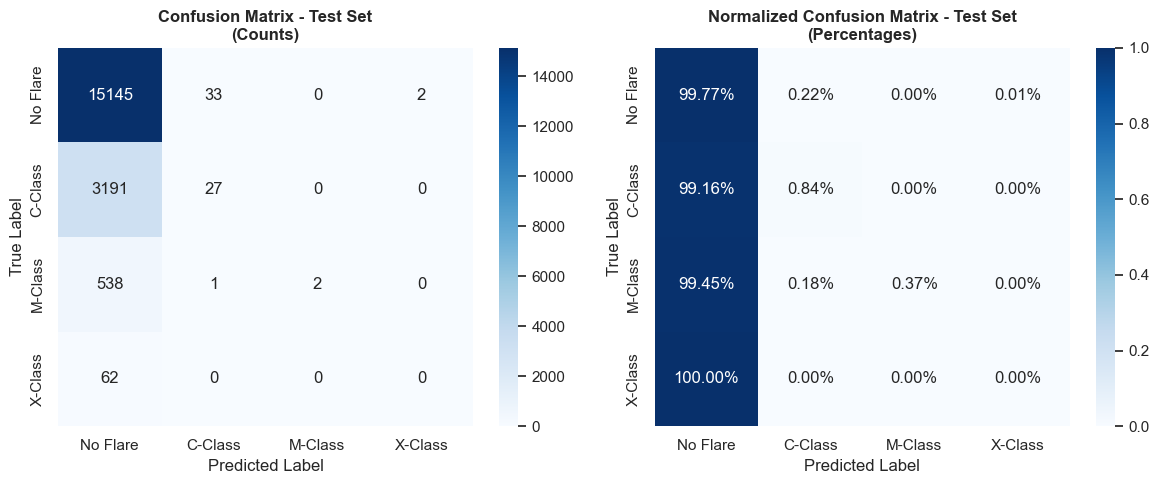

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test3, y_test_pred3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Loading and Visualizing the Data Once again

In [12]:
train_path='Train_Data_by_AR.csv'
val_path= 'Validation_Data_by_AR.csv'
test_path='Test_Data_by_AR.csv'

In [13]:
def map_flare_class(fs):
    if fs == 0 or str(fs) == "0":
        return "0"
    s = str(fs)
    if s.startswith("C"):
        return "C"
    if s.startswith("M"):
        return "M"
    if s.startswith("X"):
        return "X"
    return "other"

def flare_to_num(s):
    s = str(s)
    if s == '0':
        return 0
    elif s.startswith('C'):
        return 1
    elif s.startswith('M'):
        return 2
    elif s.startswith('X'):
        return 3
    else:
        return np.nan

def print_class_ratios(series, name=""):
    counts = series.value_counts()
    total = len(series)
    print(f"\n{name} ratios:")
    for c, v in counts.items():
        print(f"  {c}: {v} ({v / total:.3%})")


df_train , df_val, df_test = dataset_rare_classes_maximized(train_path,val_path, test_path, test_size=0.1, val_size=0.1, random_state=RANDOM_STATE)


ORIGINAL DATASET COUNTS:
Training samples: 759357
Validation samples: 95933
Test samples: 94757
Total original: 950047

Combined dataset shape: (950047, 32)

FINAL DATASET COUNTS:
Training samples: 615166
Validation samples: 127875
Test samples: 75947

VALIDATION SET CLASS DISTRIBUTION:
  Class 0: 68352 samples
  Class 1: 30000 samples
  Class 2: 26680 samples
  Class 3: 2843 samples


In [14]:
# I will use the df_Test as the main dataset for computational reasons
df=df_val

print("Shape:", df.shape)
print("Columns:")
display(df.columns.tolist())

Shape: (127875, 34)
Columns:


['grad_mean',
 'grad_std',
 'grad_median',
 'grad_min',
 'grad_max',
 'grad_skewness',
 'grad_kurtosis',
 'nl_length',
 'nl_num_fragments',
 'nl_grad_weighted_length',
 'nl_curv_mean',
 'nl_curv_std',
 'nl_curv_median',
 'nl_curv_min',
 'nl_curv_max',
 'nl_bend_energy_mean',
 'nl_bend_energy_std',
 'nl_bend_energy_median',
 'nl_bend_energy_min',
 'nl_bend_energy_max',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_unsigned',
 'flux_signed',
 'flux_negative',
 'flux_positive',
 'class_label',
 'flare_strength',
 'image_path',
 'flare_class4',
 'flare_numeric']

In [15]:
missing_cols = df.isna().any().sum()
complete_cols = len(df.columns) -missing_cols

print("Number of columns with missing values:", missing_cols)
print("Number of columns with complete values:", complete_cols)

print("Basic statistics for numeric columns:")
display(df.describe().T)

Number of columns with missing values: 0
Number of columns with complete values: 34
Basic statistics for numeric columns:


count      mean       std       min           25%  \
grad_mean                127875.0  0.209164  0.116734  0.003137  1.286525e-01   
grad_std                 127875.0  0.242128  0.096389  0.011068  1.722816e-01   
grad_median              127875.0  0.095745  0.065085  0.000000  7.329720e-02   
grad_min                 127875.0  0.039973  0.097620  0.000000  6.160000e-16   
grad_max                 127875.0  0.091820  0.070077  0.003817  5.888039e-02   
grad_skewness            127875.0  0.043480  0.040434  0.000000  2.616361e-02   
grad_kurtosis            127875.0  0.004877  0.018368  0.000000  1.311059e-03   
nl_length                127875.0  0.005841  0.007536  0.000000  2.738379e-03   
nl_num_fragments         127875.0  0.007614  0.015707  0.000000  3.033228e-03   
nl_grad_weighted_length  127875.0  0.349462  0.085193  0.013279  2.951246e-01   
nl_curv_mean             127875.0  0.266354  0.049663  0.000000  2.384835e-01   
nl_curv_std              127875.0  0.468672  0.070167  0.000000  4.296806e-01   
nl_curv_median           127875.0  0.545791  0.497624  0.000000  0.000000e+00   
nl_curv_min              127875.0  0.668801  0.305533  0.000000  4.084080e-01   
nl_curv_max              127875.0  0.000000  0.000000  0.000000  0.000000e+00   
nl_bend_energy_mean      127875.0  0.520618  0.096489  0.000000  4.608262e-01   
nl_bend_energy_std       127875.0  0.395402  0.088257  0.000000  3.357703e-01   
nl_bend_energy_median    127875.0  0.590356  0.096313  0.000000  5.344501e-01   
nl_bend_energy_min       127875.0  0.000050  0.006423  0.000000  0.000000e+00   
nl_bend_energy_max       127875.0  0.233309  0.096892  0.002131  1.534150e-01   
wavelet_energy_1         127875.0  0.140408  0.072454  0.002092  9.111228e-02   
wavelet_energy_2         127875.0  0.210836  0.117031  0.004174  1.299329e-01   
wavelet_energy_3         127875.0  0.202495  0.120509  0.008947  1.190864e-01   
wavelet_energy_4         127875.0  0.194838  0.127030  0.000134  1.071090e-01   
wavelet_energy_5         127875.0  0.193523  0.129639  0.001361  1.035952e-01   
flux_unsigned            127875.0  0.126473  0.106306  0.000005  5.886811e-02   
flux_signed              127875.0  0.856305  0.112446  0.000000  8.136695e-01   
flux_negative            127875.0  0.483320  0.081076  0.000000  4.482449e-01   
flux_positive            127875.0  0.128456  0.107812  0.000147  6.010265e-02   
class_label              127875.0  0.465478  0.498809  0.000000  0.000000e+00   
flare_numeric            127875.0  0.718585  0.867701  0.000000  0.000000e+00   

                                  50%           75%       max  
grad_mean                1.820132e-01  2.600979e-01  1.000000  
grad_std                 2.290494e-01  2.992533e-01  0.891212  
grad_median              8.613329e-02  1.035442e-01  1.000000  
grad_min                 1.740000e-15  3.480000e-15  0.877058  
grad_max                 7.264782e-02  9.810475e-02  0.807337  
grad_skewness            3.596266e-02  4.899692e-02  0.902590  
grad_kurtosis            2.097668e-03  3.404365e-03  0.770624  
nl_length                4.423536e-03  6.810841e-03  0.373789  
nl_num_fragments         4.963463e-03  7.583069e-03  0.609817  
nl_grad_weighted_length  3.553486e-01  4.123520e-01  0.873210  
nl_curv_mean             2.791289e-01  3.014848e-01  0.943117  
nl_curv_std              4.856674e-01  5.182864e-01  0.951417  
nl_curv_median           1.000000e+00  1.000000e+00  1.000000  
nl_curv_min              7.051395e-01  1.000000e+00  1.000000  
nl_curv_max              0.000000e+00  0.000000e+00  0.000000  
nl_bend_energy_mean      5.233359e-01  5.842428e-01  1.000000  
nl_bend_energy_std       3.940196e-01  4.531036e-01  1.000000  
nl_bend_energy_median    5.987126e-01  6.553806e-01  0.961925  
nl_bend_energy_min       0.000000e+00  0.000000e+00  1.000000  
nl_bend_energy_max       2.351085e-01  2.895709e-01  1.000000  
wavelet_energy_1         1.244864e-01  1.717861e-01  1.000000  
wavelet_energy_2         1.

In [16]:
all_columns = df.columns.tolist()

non_feature_cols = ["class_label", "flare_strength", "image_path","flare_class4","flare_numeric"]

feature_cols = [c for c in all_columns if c not in non_feature_cols]

print("Number of feature columns:", len(feature_cols))
print("Feature columns:")
print(feature_cols)

print("\nNon-feature columns:")
print(non_feature_cols)

Number of feature columns: 29
Feature columns:
['grad_mean', 'grad_std', 'grad_median', 'grad_min', 'grad_max', 'grad_skewness', 'grad_kurtosis', 'nl_length', 'nl_num_fragments', 'nl_grad_weighted_length', 'nl_curv_mean', 'nl_curv_std', 'nl_curv_median', 'nl_curv_min', 'nl_curv_max', 'nl_bend_energy_mean', 'nl_bend_energy_std', 'nl_bend_energy_median', 'nl_bend_energy_min', 'nl_bend_energy_max', 'wavelet_energy_1', 'wavelet_energy_2', 'wavelet_energy_3', 'wavelet_energy_4', 'wavelet_energy_5', 'flux_unsigned', 'flux_signed', 'flux_negative', 'flux_positive']

Non-feature columns:
['class_label', 'flare_strength', 'image_path', 'flare_class4', 'flare_numeric']


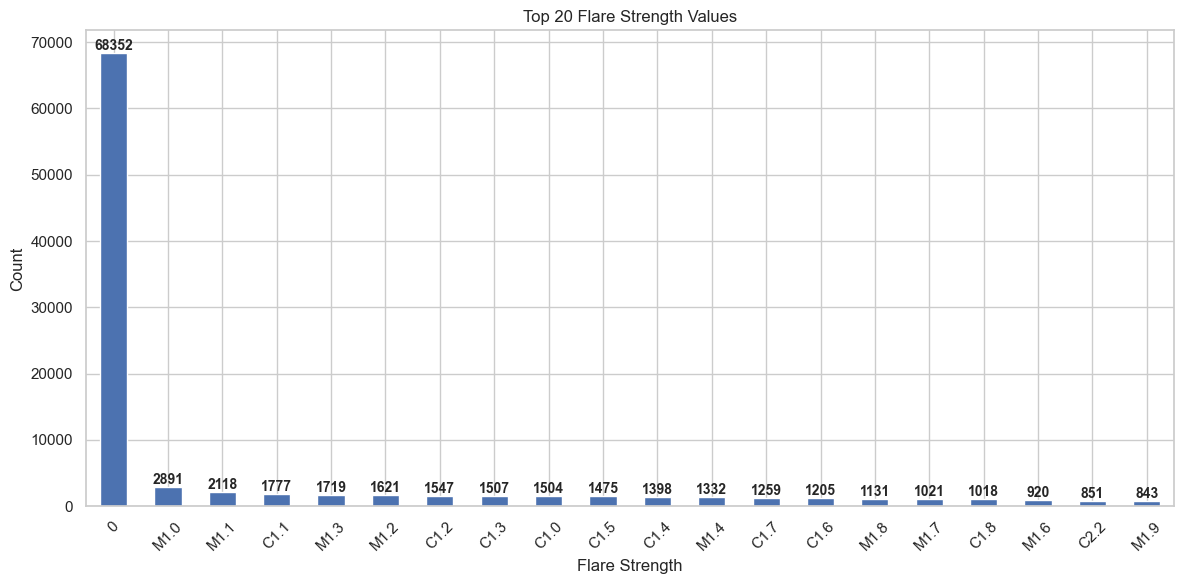

In [17]:
plt.figure(figsize=(12, 6))
ax = df["flare_strength"].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Flare Strength Values")
plt.xlabel("Flare Strength")
plt.ylabel("Count")
plt.xticks(rotation=45)
for i, v in enumerate(df["flare_strength"].value_counts().head(20)):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


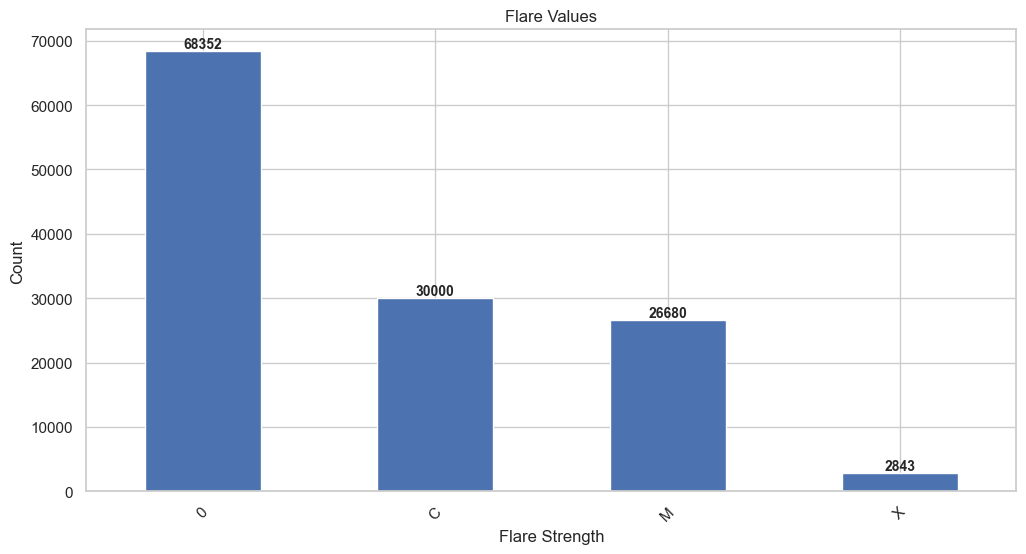


flare_class4 ratios:
  0: 68352 (53.452%)
  C: 30000 (23.460%)
  M: 26680 (20.864%)
  X: 2843 (2.223%)


In [18]:

plt.figure(figsize=(12, 6))
ax = df["flare_class4"].value_counts().plot(kind='bar')
plt.title("Flare Values")
plt.xlabel("Flare Strength")
plt.ylabel("Count")
plt.xticks(rotation=45)
for i, v in enumerate(df["flare_class4"].value_counts().head(20)):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

print_class_ratios(df["flare_class4"],"flare_class4")

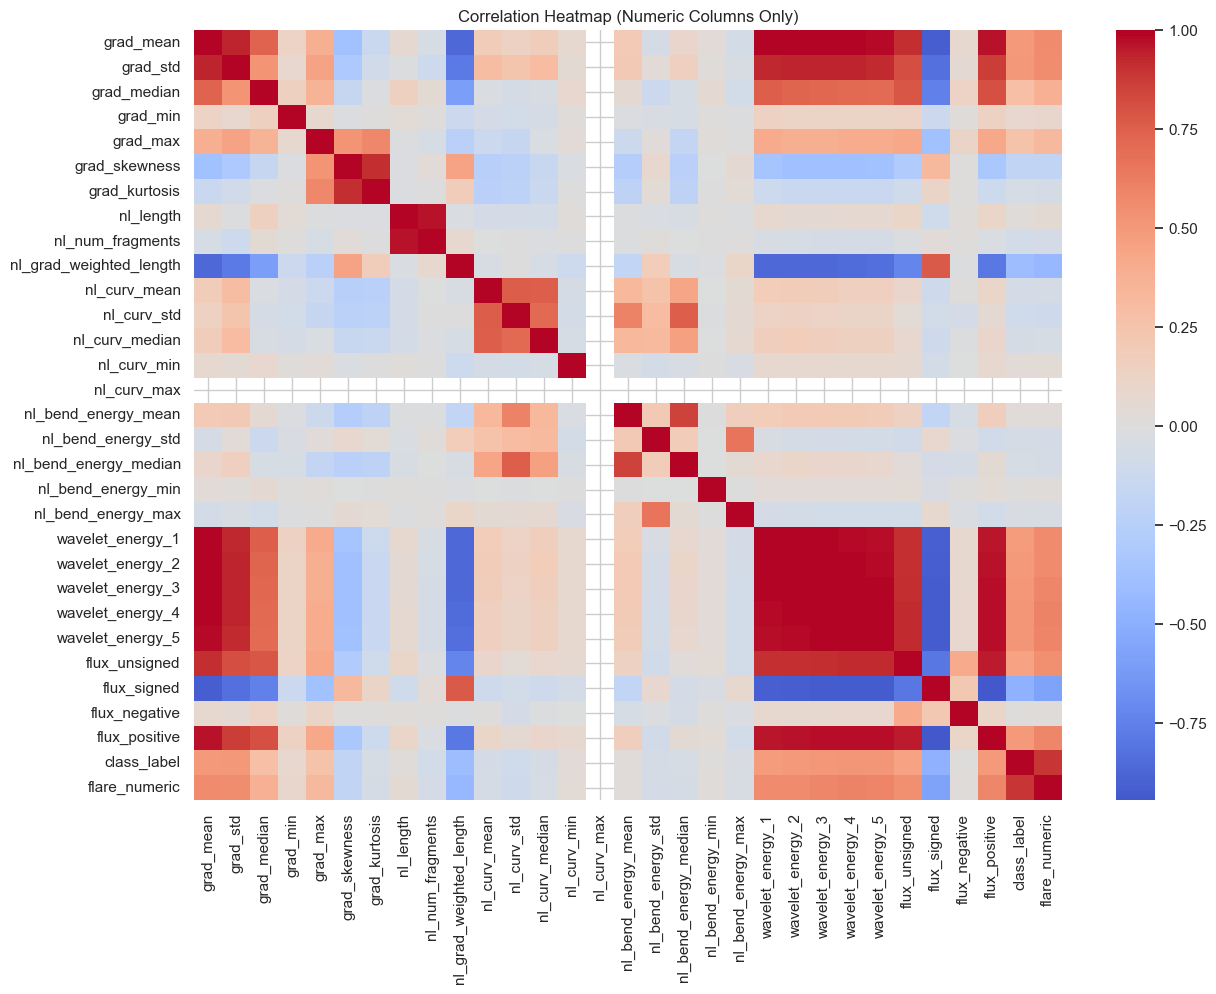

In [19]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_21240\1233233017.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corrs.values, y=corrs.index, palette='coolwarm')


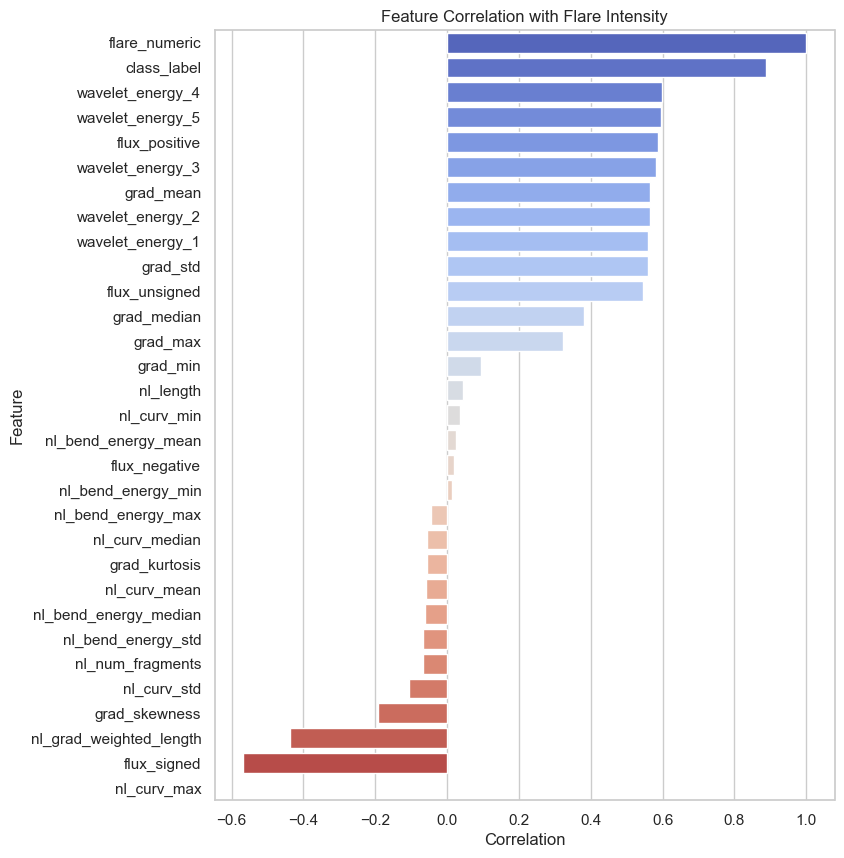

In [20]:
# polting the correlation with the numeric value of flare strength

corrs = numeric_df.corr()['flare_numeric'].sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x=corrs.values, y=corrs.index, palette='coolwarm')
plt.title("Feature Correlation with Flare Intensity")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

# Model 4
kernel = rfb

No Weights

C=1


In [31]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


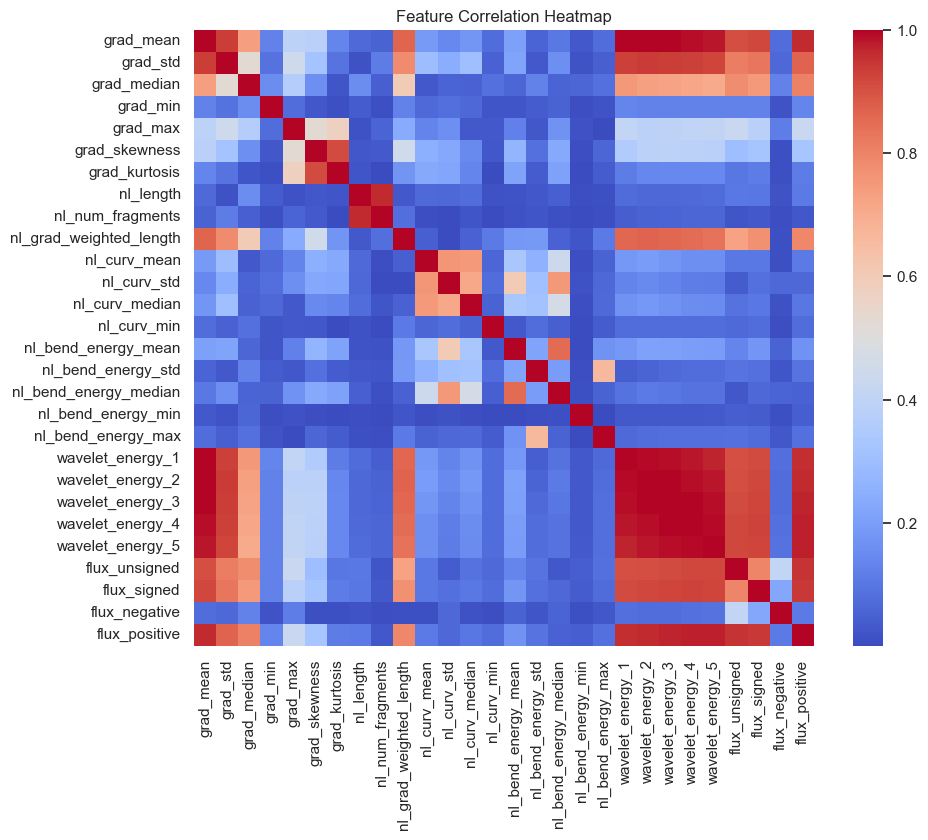

In [32]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

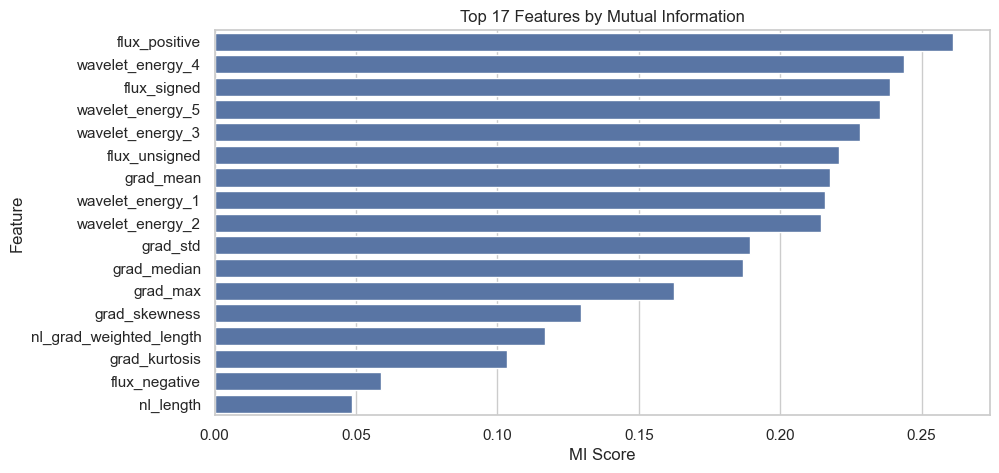

(127875, 18)

In [33]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


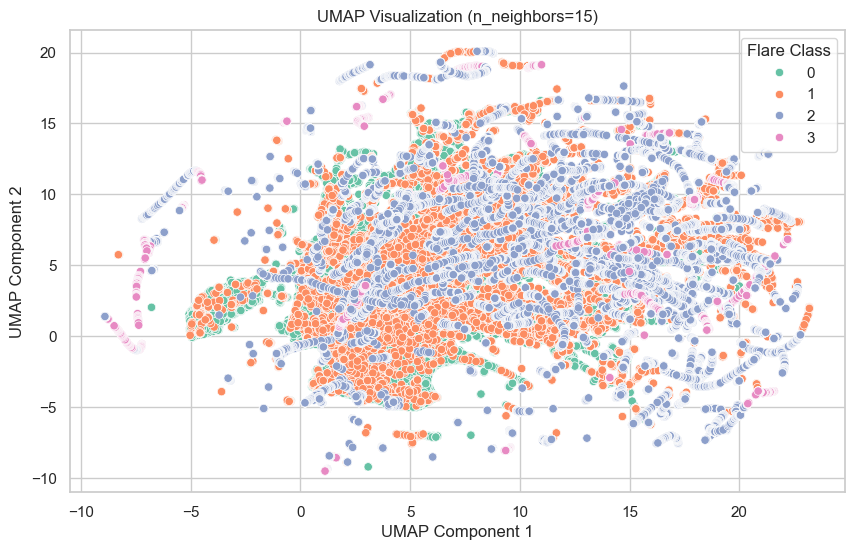

UMAP completed on 127875 samples


In [34]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [35]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [36]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train6=scaler.fit_transform(training_df[selected_features])
Y_train6=training_df['flare_numeric']

X_val6 = scaler.transform(validating_df[selected_features])
y_val6 = validating_df['flare_numeric']

X_test6 = scaler.transform(testing_df[selected_features])
y_test6 = testing_df['flare_numeric']

print("Training samples:", len(X_train6))
print("Validation samples:",len(X_val6))
print("Test samples:",len(X_test6))
print("Total samples:", str(len(X_train6) + len(X_val6) + len(X_test6)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


## Training

In [37]:
from sklearn.svm import SVC
svm_model6=SVC(kernel='rbf', random_state=42)

svm_model6.fit(X_train6, Y_train6)

y_train_pred6 = svm_model6.predict(X_train6)
y_test_pred6 = svm_model6.predict(X_test6)

In [41]:
train_accuracy_6 = accuracy_score(Y_train6, y_train_pred6)
test_accuracy_6 = accuracy_score(y_test6, y_test_pred6)
test_precision_6 = precision_score(y_test6, y_test_pred6, average='weighted', zero_division=0)
test_recall_6 = recall_score(y_test6, y_test_pred6, average='weighted', zero_division=0)
test_f1_6 = f1_score(y_test6, y_test_pred6, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_6:.4f} ({train_accuracy_6*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_6:.4f} ({test_accuracy_6*100:.2f}%)")
print(f"PRECISION:         {test_precision_6:.4f}")
print(f"RECALL:            {test_recall_6:.4f}")
print(f"F1-SCORE:          {test_f1_6:.4f}")

TRAINING ACCURACY: 0.7022 (70.22%)
TEST ACCURACY:     0.6979 (69.79%)
PRECISION:         0.6720
RECALL:            0.6979
F1-SCORE:          0.6632


In [42]:
print(classification_report(y_test6, y_test_pred6, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.73      0.92      0.82     13670
     C-Class       0.52      0.22      0.31      6000
     M-Class       0.66      0.69      0.67      5336
     X-Class       0.91      0.47      0.62       569

    accuracy                           0.70     25575
   macro avg       0.71      0.57      0.60     25575
weighted avg       0.67      0.70      0.66     25575



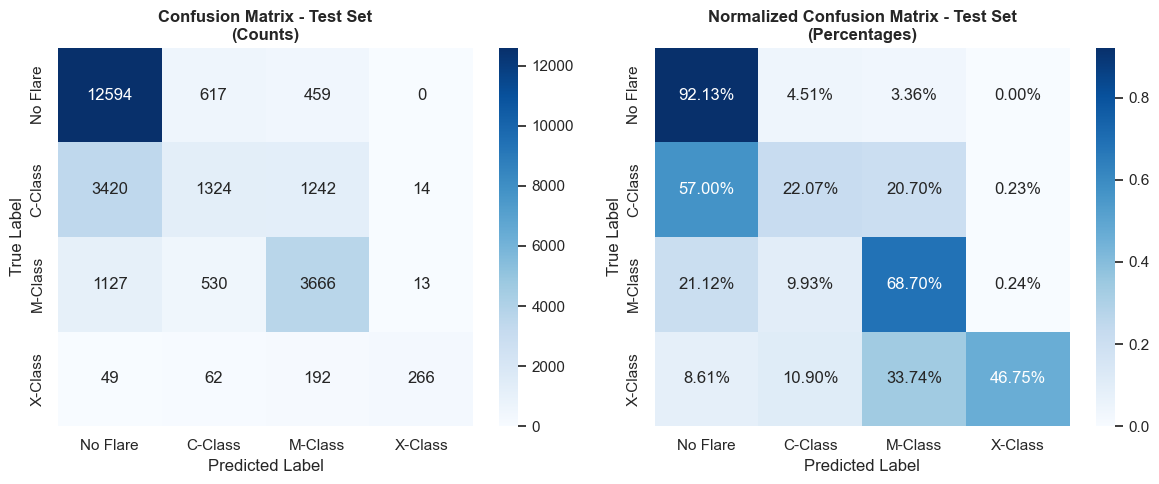

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test6, y_test_pred6)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 5

kernel = linear

Weights= {0: 0.4677098827143937,1: 1.065625,2: 1.1982290104947526,3: 11.243405627198124}

C=1

In [41]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


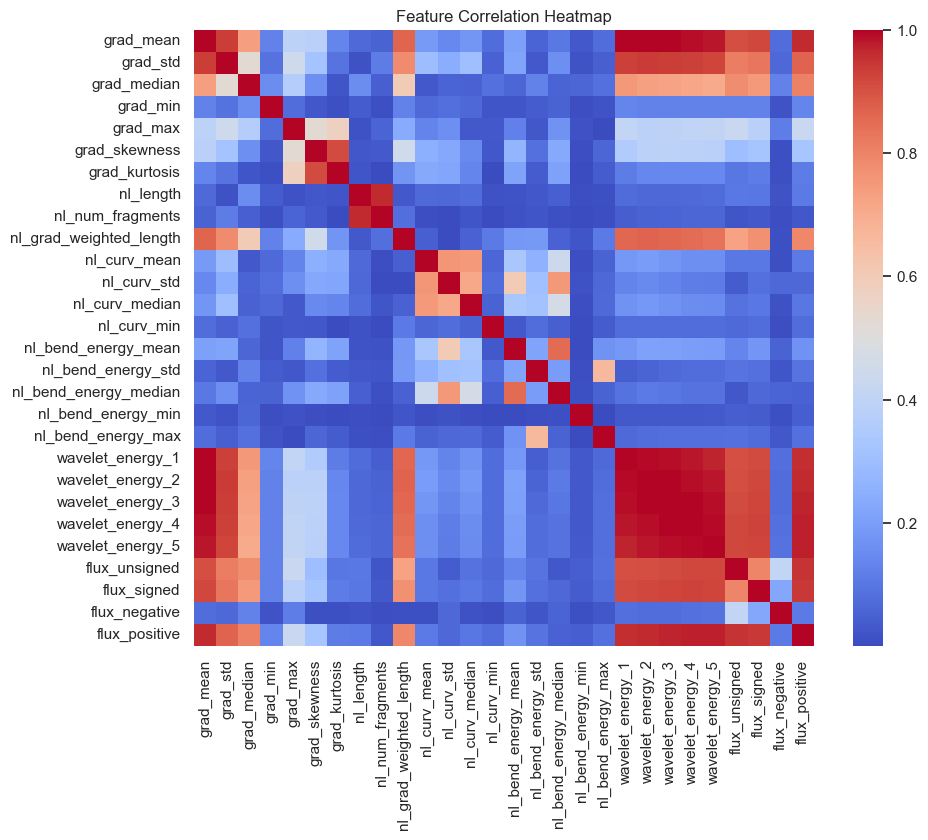

In [44]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

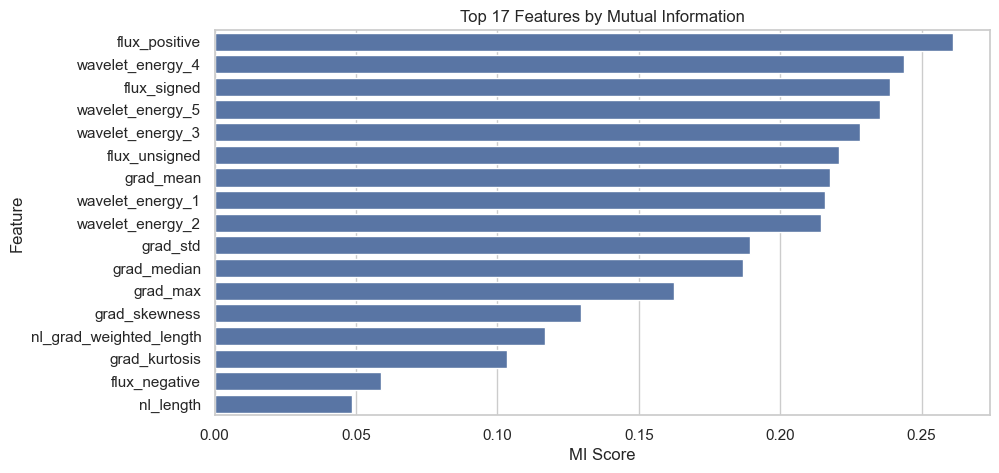

(127875, 18)

In [45]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


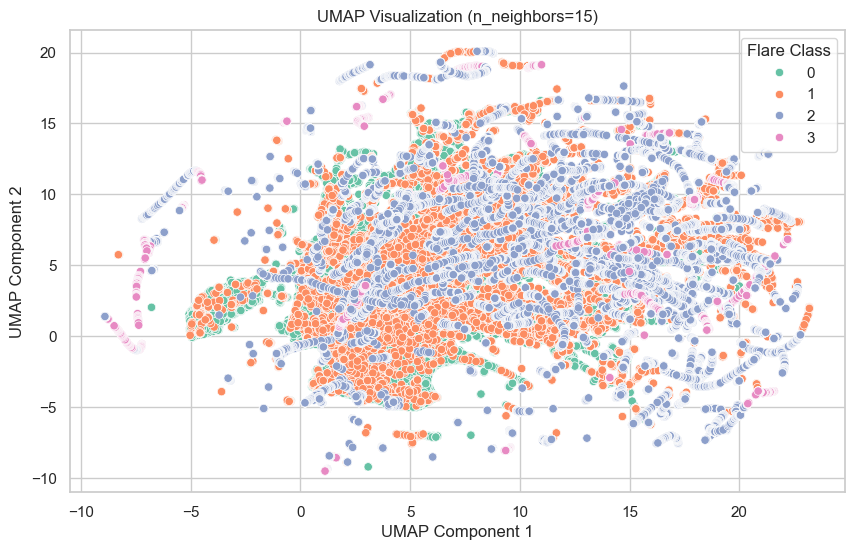

UMAP completed on 127875 samples


In [46]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [47]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [48]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train4=scaler.fit_transform(training_df[selected_features])
Y_train4=training_df['flare_numeric']

X_val4 = scaler.transform(validating_df[selected_features])
y_val4 = validating_df['flare_numeric']

X_test4 = scaler.transform(testing_df[selected_features])
y_test4 = testing_df['flare_numeric']

print("Training samples:", len(X_train4))
print("Validation samples:",len(X_val4))
print("Test samples:",len(X_test4))
print("Total samples:", str(len(X_train4) + len(X_val4) + len(X_test4)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


## Training

In [54]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(Y_train4), 
    y=Y_train4
)
class_weight_dict = dict(enumerate(class_weights))
display(class_weight_dict)

{0: np.float64(0.4677098827143937),
 1: np.float64(1.065625),
 2: np.float64(1.1982290104947526),
 3: np.float64(11.243405627198124)}

In [ ]:
from sklearn.svm import SVC
svm_model4=SVC(kernel='linear',class_weight=class_weight_dict, random_state=42)

svm_model4.fit(X_train4, Y_train4)

y_train_pred4 = svm_model4.predict(X_train4)
y_test_pred4 = svm_model4.predict(X_test4)

In [64]:
train_accuracy_4 = accuracy_score(Y_train4, y_train_pred4)
test_accuracy_4 = accuracy_score(y_test4, y_test_pred4)
test_precision_4 = precision_score(y_test4, y_test_pred4, average='weighted', zero_division=0)
test_recall_4 = recall_score(y_test4, y_test_pred4, average='weighted', zero_division=0)
test_f1_4 = f1_score(y_test4, y_test_pred4, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_4:.4f} ({train_accuracy_4*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_4:.4f} ({test_accuracy_4*100:.2f}%)")
print(f"PRECISION:         {test_precision_4:.4f}")
print(f"RECALL:            {test_recall_4:.4f}")
print(f"F1-SCORE:          {test_f1_4:.4f}")

TRAINING ACCURACY: 0.6251 (62.51%)
TEST ACCURACY:     0.6291 (62.91%)
PRECISION:         0.6630
RECALL:            0.6291
F1-SCORE:          0.6404


In [65]:
print(classification_report(y_test4, y_test_pred4, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.82      0.78      0.80     13670
     C-Class       0.38      0.41      0.40      6000
     M-Class       0.62      0.47      0.54      5336
     X-Class       0.19      0.69      0.30       569

    accuracy                           0.63     25575
   macro avg       0.50      0.59      0.51     25575
weighted avg       0.66      0.63      0.64     25575



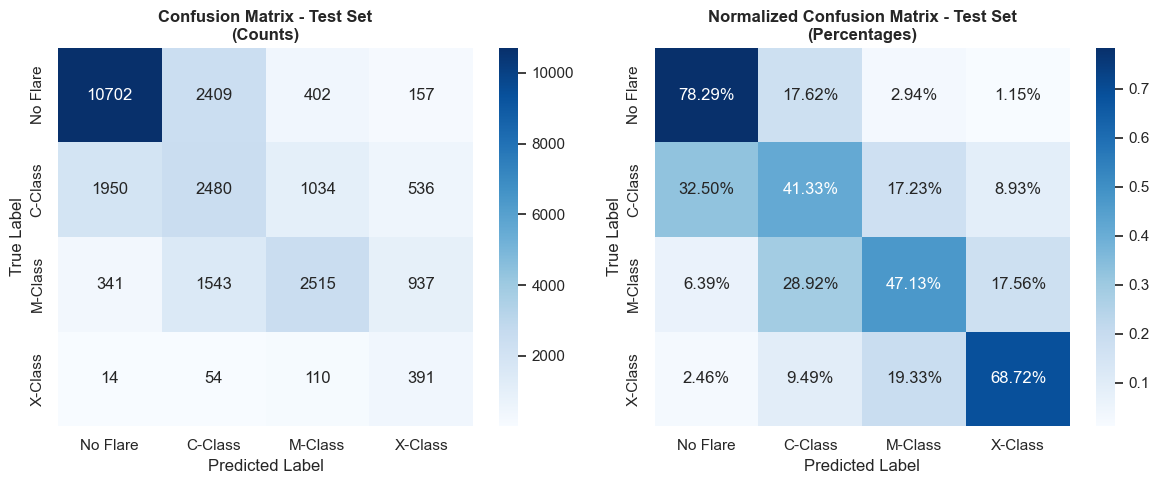

In [66]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test4, y_test_pred4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 6
kernel = rfb

Weights={0: 0.4677098827143937,1: 1.065625, 2: 1.1982290104947526,3: 11.243405627198124}

C=1

In [58]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


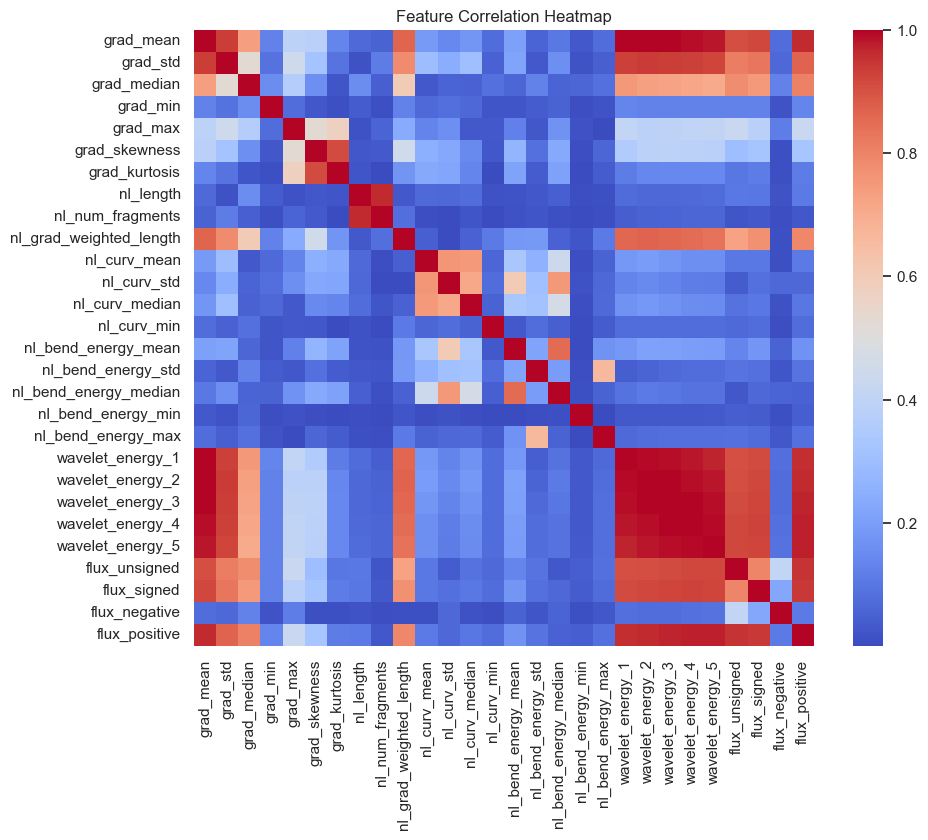

In [67]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

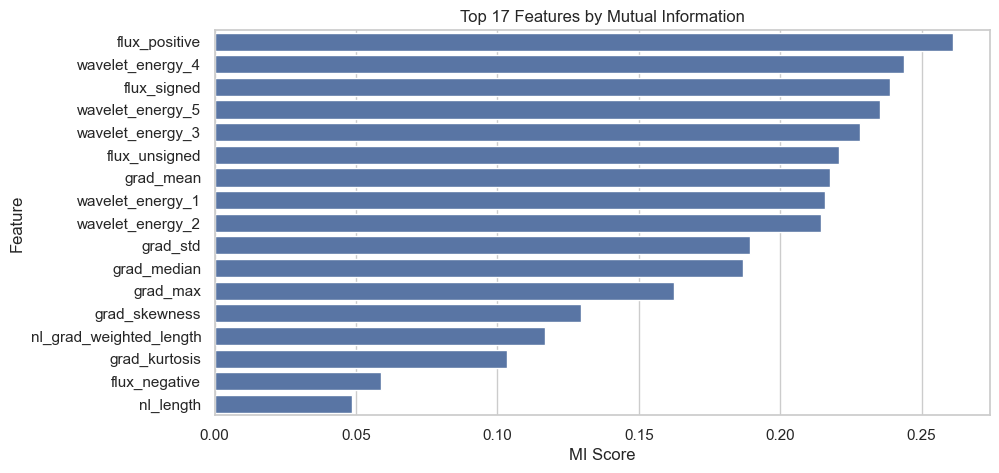

(127875, 18)

In [68]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


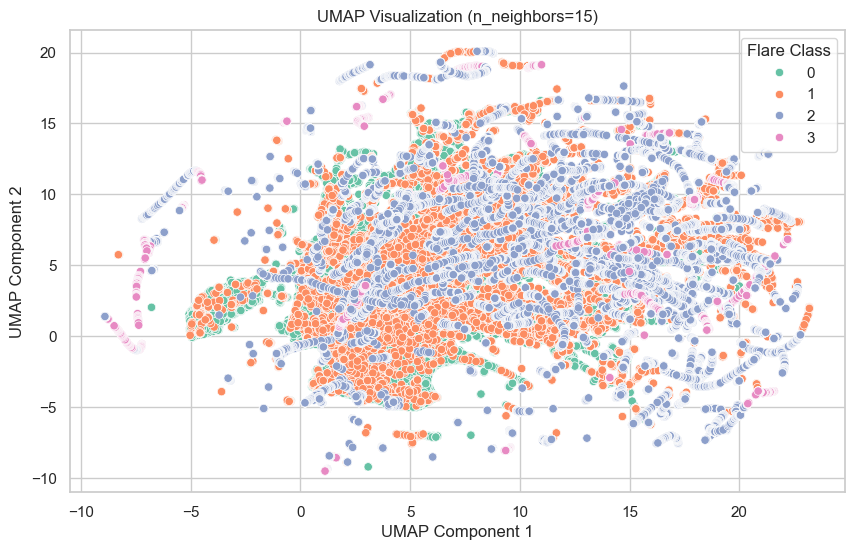

UMAP completed on 127875 samples


In [69]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [70]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [71]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train5=scaler.fit_transform(training_df[selected_features])
Y_train5=training_df['flare_numeric']

X_val5 = scaler.transform(validating_df[selected_features])
y_val5 = validating_df['flare_numeric']

X_test5 = scaler.transform(testing_df[selected_features])
y_test5 = testing_df['flare_numeric']

print("Training samples:", len(X_train5))
print("Validation samples:",len(X_val5))
print("Test samples:",len(X_test5))
print("Total samples:", str(len(X_train5) + len(X_val5) + len(X_test5)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


## Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(Y_train5), 
    y=Y_train5
)
class_weight_dict = dict(enumerate(class_weights))
display(class_weight_dict)

{0: np.float64(0.4677098827143937),
 1: np.float64(1.065625),
 2: np.float64(1.1982290104947526),
 3: np.float64(11.243405627198124)}

In [73]:
from sklearn.svm import SVC
import numpy as np

svm_model5 = SVC(kernel='rbf', class_weight=class_weight_dict, random_state=42)

svm_model5.fit(X_train5, Y_train5)

y_train_pred5 = svm_model5.predict(X_train5)
y_test_pred5 = svm_model5.predict(X_test5)

In [74]:
train_accuracy_5 = accuracy_score(Y_train5, y_train_pred5)
test_accuracy_5 = accuracy_score(y_test5, y_test_pred5)
test_precision_5 = precision_score(y_test5, y_test_pred5, average='weighted', zero_division=0)
test_recall_5 = recall_score(y_test5, y_test_pred5, average='weighted', zero_division=0)
test_f1_5 = f1_score(y_test5, y_test_pred5, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_5:.4f} ({train_accuracy_5*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_5:.4f} ({test_accuracy_5*100:.2f}%)")
print(f"PRECISION:         {test_precision_5:.4f}")
print(f"RECALL:            {test_recall_5:.4f}")
print(f"F1-SCORE:          {test_f1_5:.4f}")

TRAINING ACCURACY: 0.6698 (66.98%)
TEST ACCURACY:     0.6674 (66.74%)
PRECISION:         0.6872
RECALL:            0.6674
F1-SCORE:          0.6733


In [75]:
print(classification_report(y_test5, y_test_pred5, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.83      0.75      0.79     13670
     C-Class       0.43      0.44      0.44      6000
     M-Class       0.63      0.68      0.66      5336
     X-Class       0.38      0.95      0.55       569

    accuracy                           0.67     25575
   macro avg       0.57      0.70      0.61     25575
weighted avg       0.69      0.67      0.67     25575



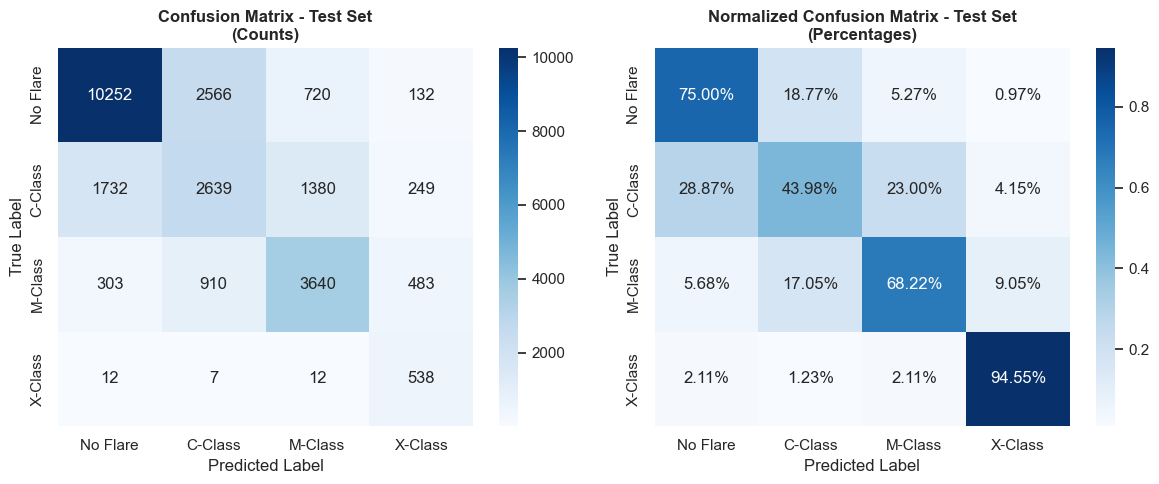

In [76]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test5, y_test_pred5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 7
kernel = rfb

Weights={0: 0.4677098827143937, 1: 1.065625, 2: 1.1982290104947526, 3: 11.243405627198124}

C=3

In [77]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


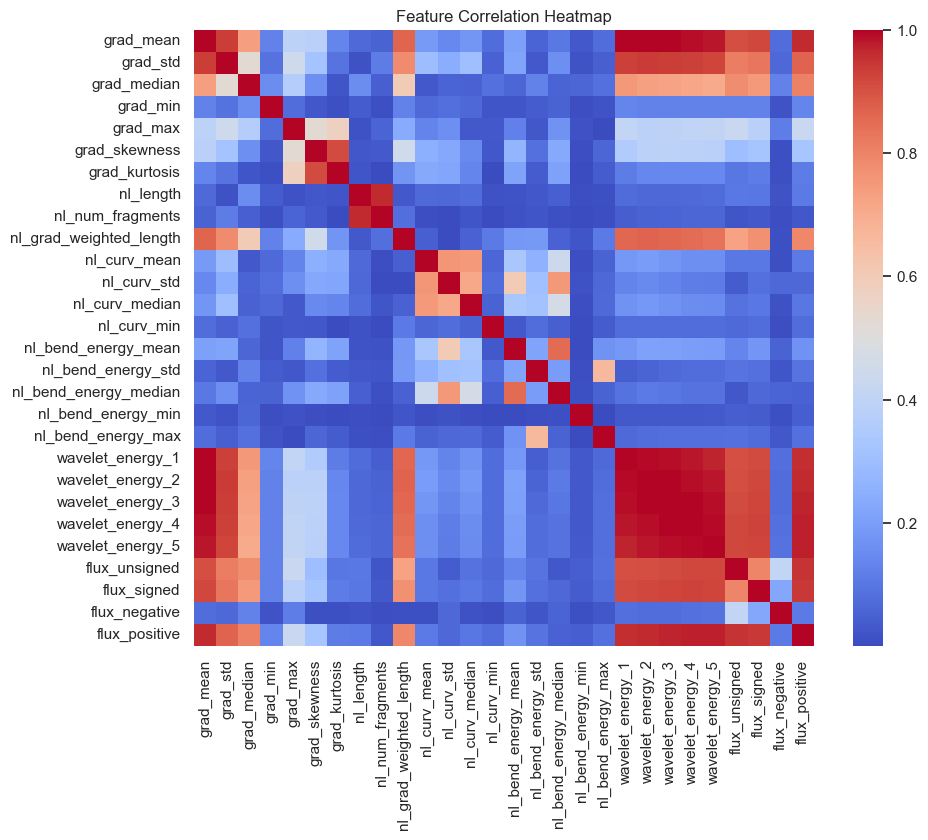

In [78]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

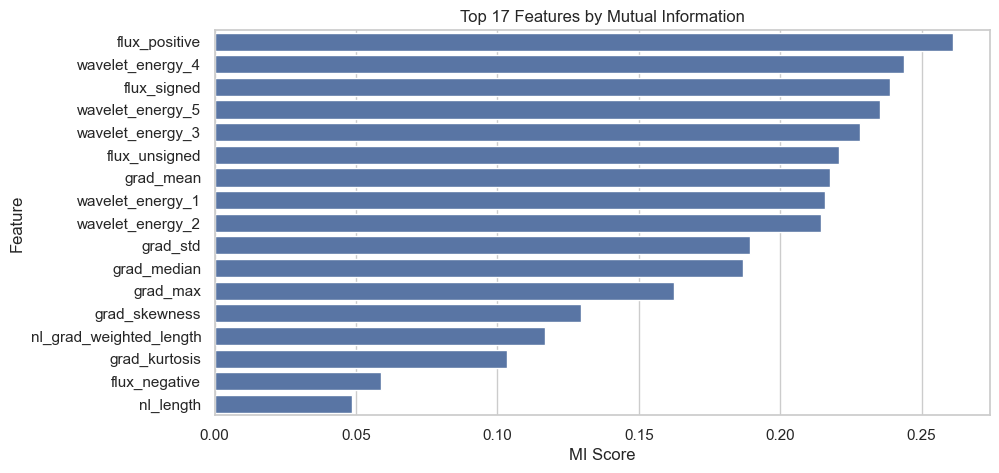

(127875, 18)

In [79]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


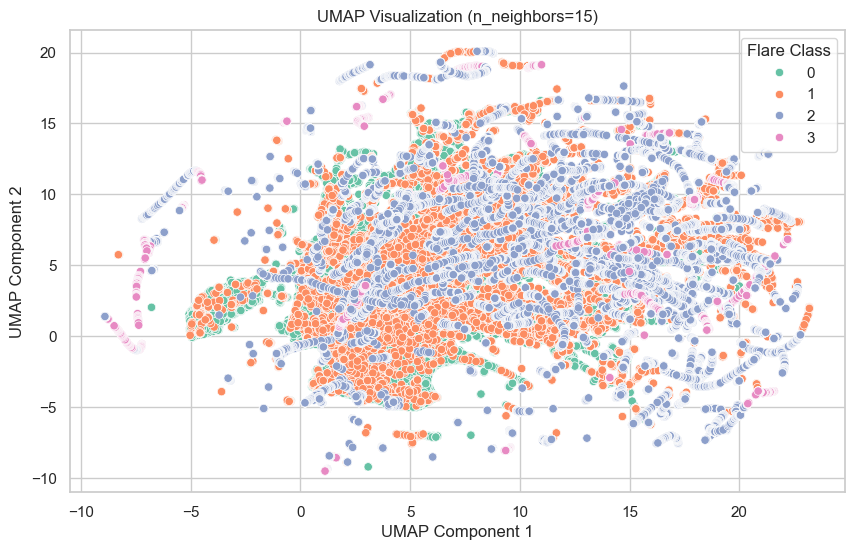

UMAP completed on 127875 samples


In [80]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [81]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [82]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train8=scaler.fit_transform(training_df[selected_features])
Y_train8=training_df['flare_numeric']

X_val8 = scaler.transform(validating_df[selected_features])
y_val8 = validating_df['flare_numeric']

X_test8 = scaler.transform(testing_df[selected_features])
y_test8 = testing_df['flare_numeric']

print("Training samples:", len(X_train8))
print("Validation samples:",len(X_val8))
print("Test samples:",len(X_test8))
print("Total samples:", str(len(X_train8) + len(X_val8) + len(X_test8)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


## Training

In [84]:
from sklearn.svm import SVC
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train8), y=Y_train8)
class_weight_dict = dict(enumerate(class_weights))

svm_model8 = SVC(kernel='rbf',C=3, class_weight=class_weight_dict, random_state=42)

svm_model8.fit(X_train8, Y_train8)

y_train_pred8 = svm_model8.predict(X_train8)
y_test_pred8 = svm_model8.predict(X_test8)

In [85]:
train_accuracy_8 = accuracy_score(Y_train8, y_train_pred8)
test_accuracy_8 = accuracy_score(y_test8, y_test_pred8)
test_precision_8 = precision_score(y_test8, y_test_pred8, average='weighted', zero_division=0)
test_recall_8 = recall_score(y_test8, y_test_pred8, average='weighted', zero_division=0)
test_f1_8 = f1_score(y_test8, y_test_pred8, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_8:.4f} ({train_accuracy_8*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_8:.4f} ({test_accuracy_8*100:.2f}%)")
print(f"PRECISION:         {test_precision_8:.4f}")
print(f"RECALL:            {test_recall_8:.4f}")
print(f"F1-SCORE:          {test_f1_8:.4f}")

TRAINING ACCURACY: 0.6887 (68.87%)
TEST ACCURACY:     0.6840 (68.40%)
PRECISION:         0.6998
RECALL:            0.6840
F1-SCORE:          0.6886


In [88]:
print(classification_report(y_test8, y_test_pred8, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.84      0.76      0.79     13670
     C-Class       0.44      0.46      0.45      6000
     M-Class       0.66      0.72      0.69      5336
     X-Class       0.48      0.97      0.64       569

    accuracy                           0.68     25575
   macro avg       0.60      0.73      0.64     25575
weighted avg       0.70      0.68      0.69     25575



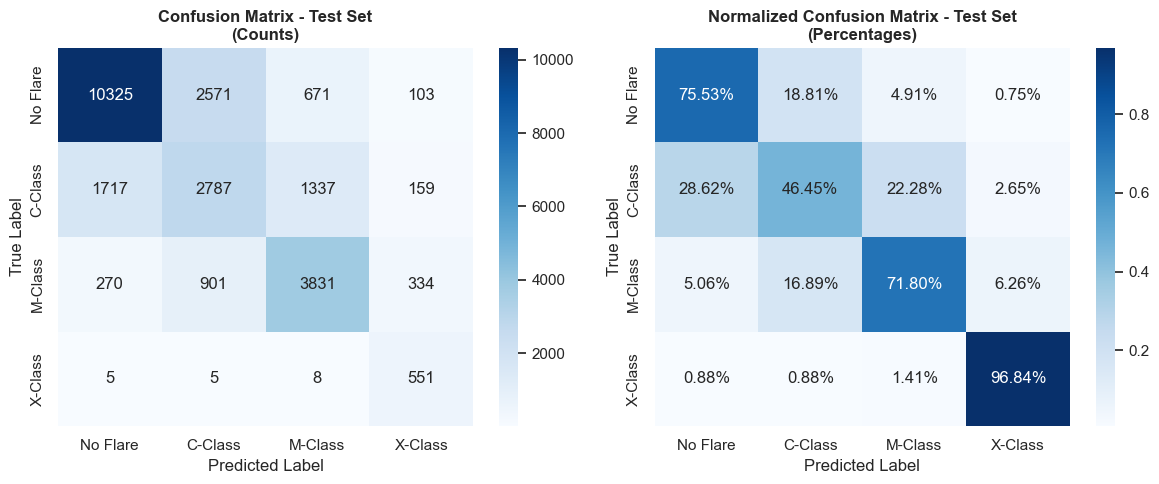

In [87]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test8, y_test_pred8)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 8
Smote self made sampling strat

kernel =rfb

Weights

C=1

In [89]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


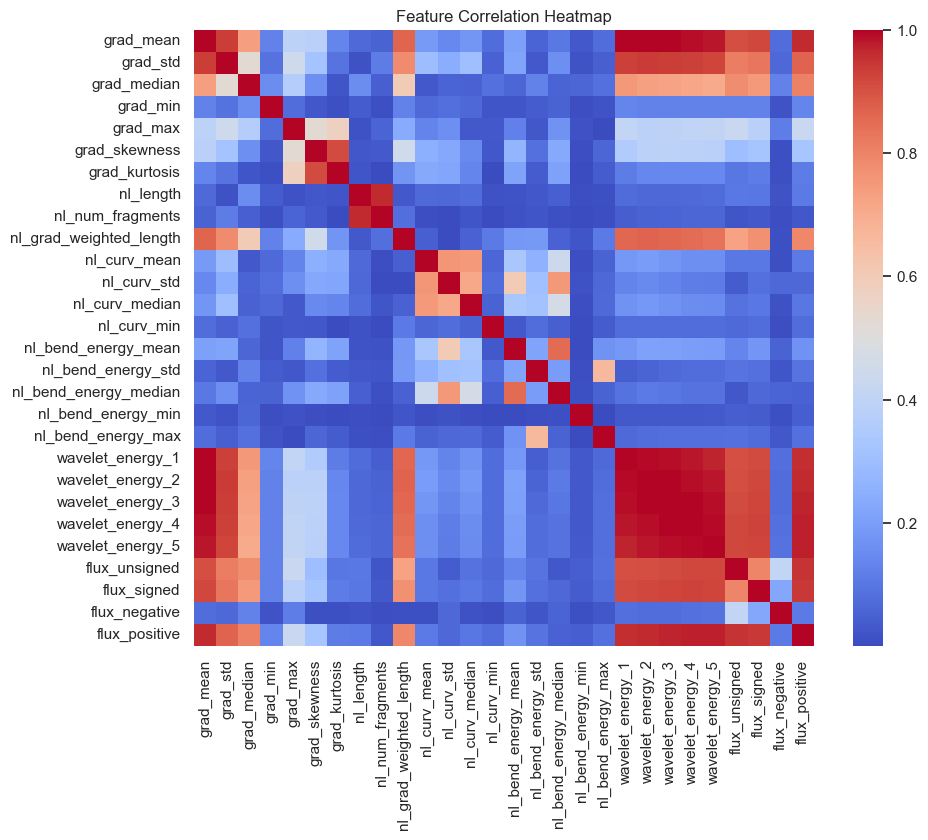

In [90]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

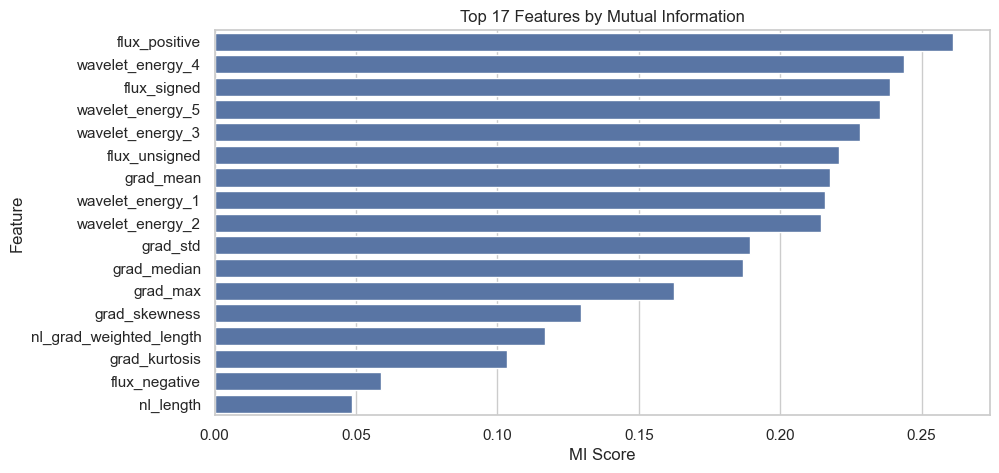

(127875, 18)

In [91]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


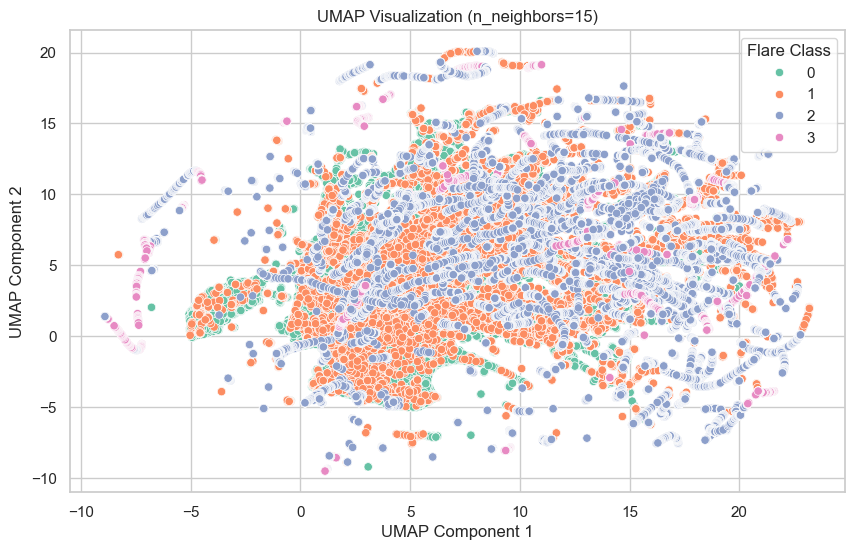

UMAP completed on 127875 samples


In [92]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [93]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [94]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train7=scaler.fit_transform(training_df[selected_features])
Y_train7=training_df['flare_numeric']

X_val7 = scaler.transform(validating_df[selected_features])
y_val7 = validating_df['flare_numeric']

X_test7 = scaler.transform(testing_df[selected_features])
y_test7 = testing_df['flare_numeric']

print("Training samples:", len(X_train7))
print("Validation samples:",len(X_val7))
print("Test samples:",len(X_test7))
print("Total samples:", str(len(X_train7) + len(X_val7) + len(X_test7)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


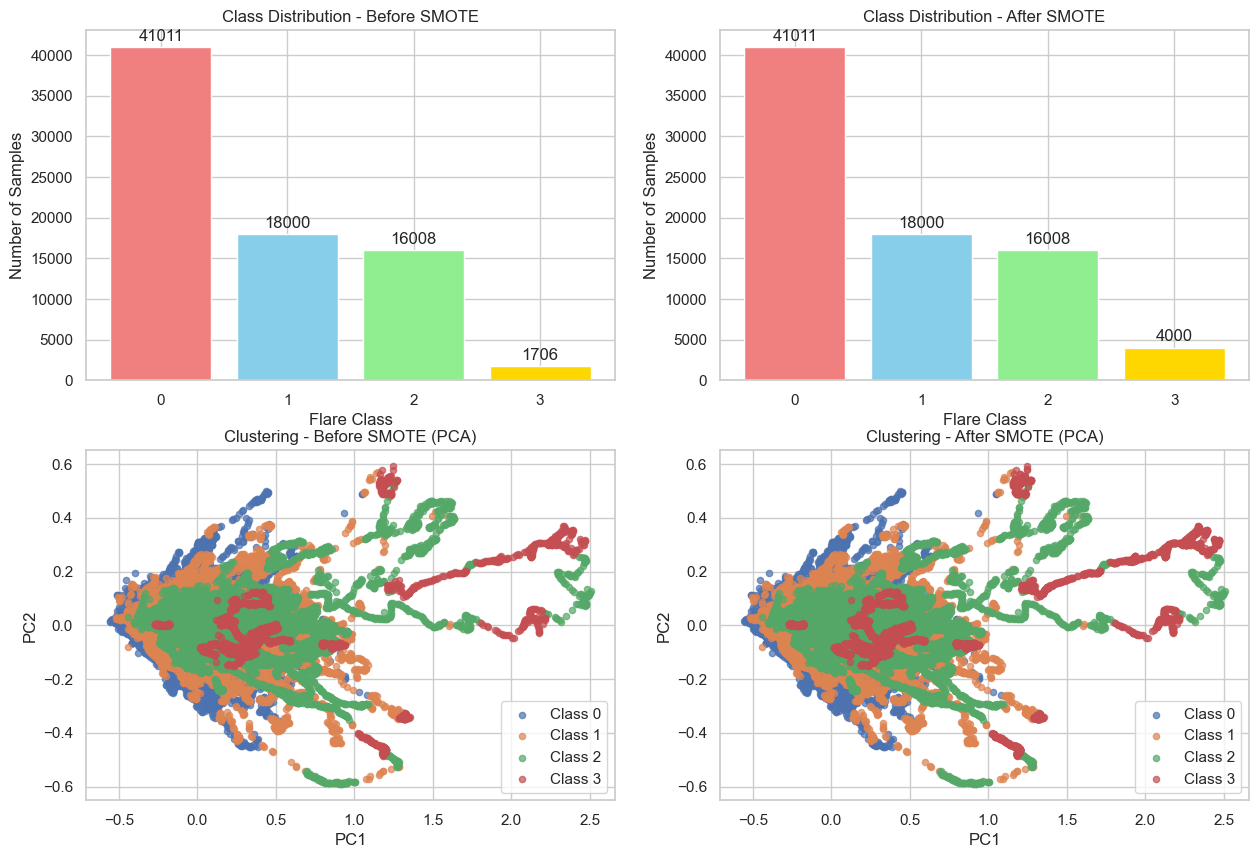


Total samples increased from 76725 to 79019


In [96]:
ss={3:4000}
X_train7, Y_train7, smote_model = apply_smote_balancing(df_filtered=training_df, selected_features=selected_features,target_col='flare_numeric',k_neighbors=3,random_state=RANDOM_STATE,sampling_strat=ss)

## Training

In [ ]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train7), y=Y_train7)
class_weight_dict = dict(enumerate(class_weights))

svm_model7 = SVC(kernel='rbf', class_weight=class_weight_dict, random_state=42)

svm_model7.fit(X_train7, Y_train7)

y_train_pred7 = svm_model7.predict(X_train7)
y_test_pred7 = svm_model7.predict(X_test7)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
train_accuracy_7 = accuracy_score(Y_train7, y_train_pred7)
test_accuracy_7 = accuracy_score(y_test7, y_test_pred7)
test_precision_7 = precision_score(y_test7, y_test_pred7, average='weighted', zero_division=0)
test_recall_7 = recall_score(y_test7, y_test_pred7, average='weighted', zero_division=0)
test_f1_7 = f1_score(y_test7, y_test_pred7, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_7:.4f} ({train_accuracy_7*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_7:.4f} ({test_accuracy_7*100:.2f}%)")
print(f"PRECISION:         {test_precision_7:.4f}")
print(f"RECALL:            {test_recall_7:.4f}")
print(f"F1-SCORE:          {test_f1_7:.4f}")

TRAINING ACCURACY: 0.6277 (62.77%)
TEST ACCURACY:     0.6085 (60.85%)
PRECISION:         0.7365
RECALL:            0.6085
F1-SCORE:          0.4608


In [ ]:
print(classification_report(y_test7, y_test_pred7, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.61      1.00      0.76     13671
     C-Class       1.00      0.00      0.00      2899
     M-Class       1.00      0.00      0.00      5336
     X-Class       0.00      0.00      0.00       569

    accuracy                           0.61     22475
   macro avg       0.65      0.25      0.19     22475
weighted avg       0.74      0.61      0.46     22475



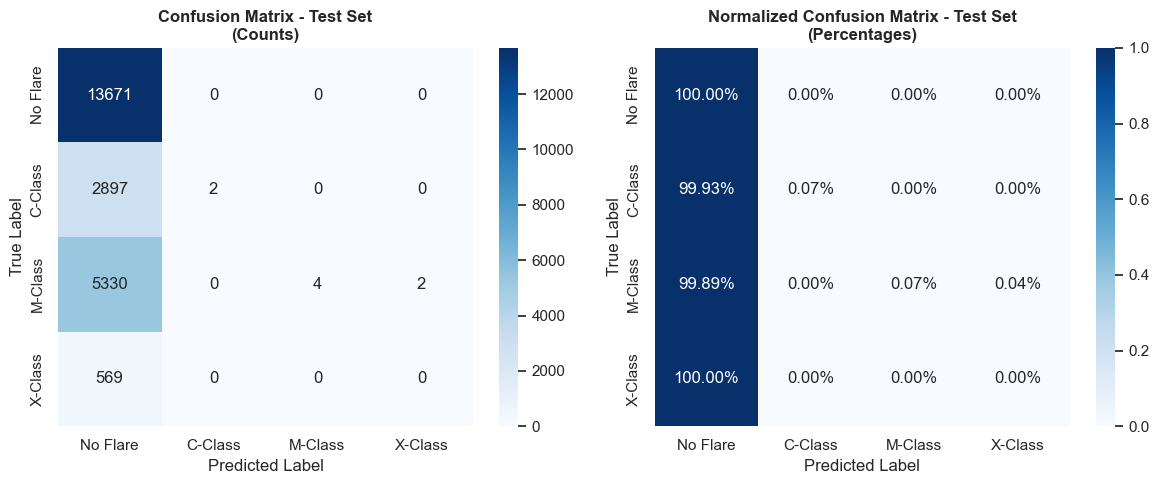

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test7, y_test_pred7)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 9
Smote self made sampling strat

kernel = linear

C=1

Weights

In [97]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


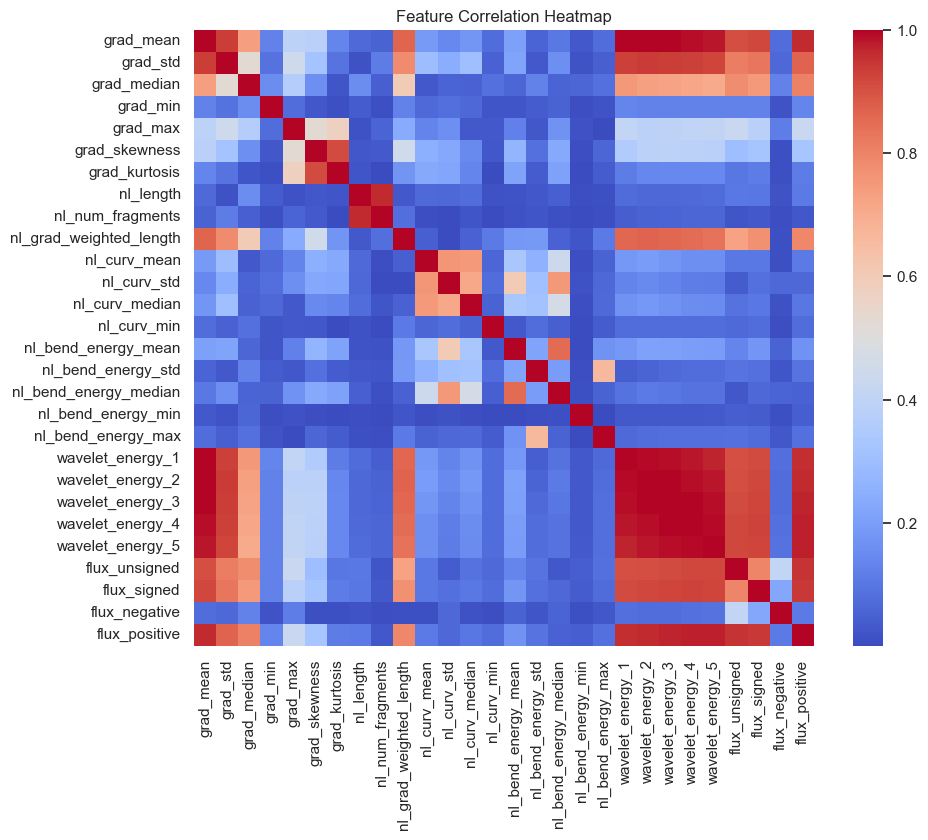

In [98]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

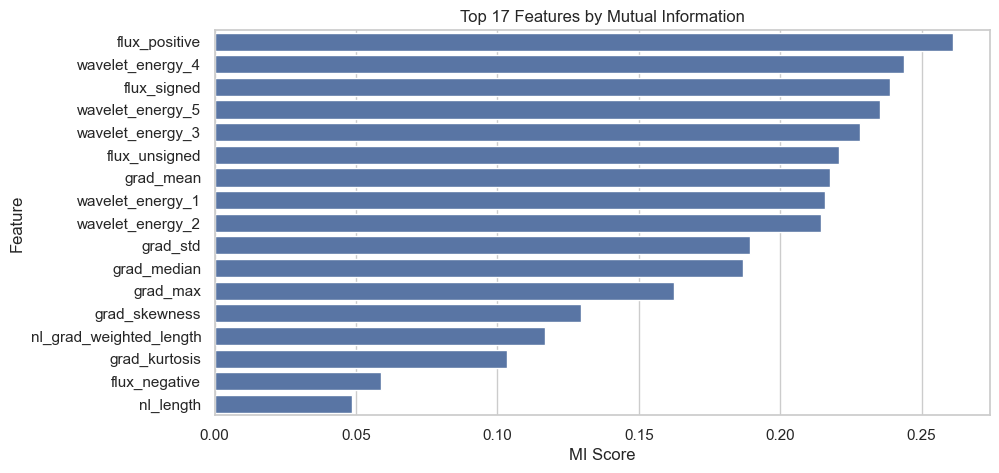

(127875, 18)

In [99]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


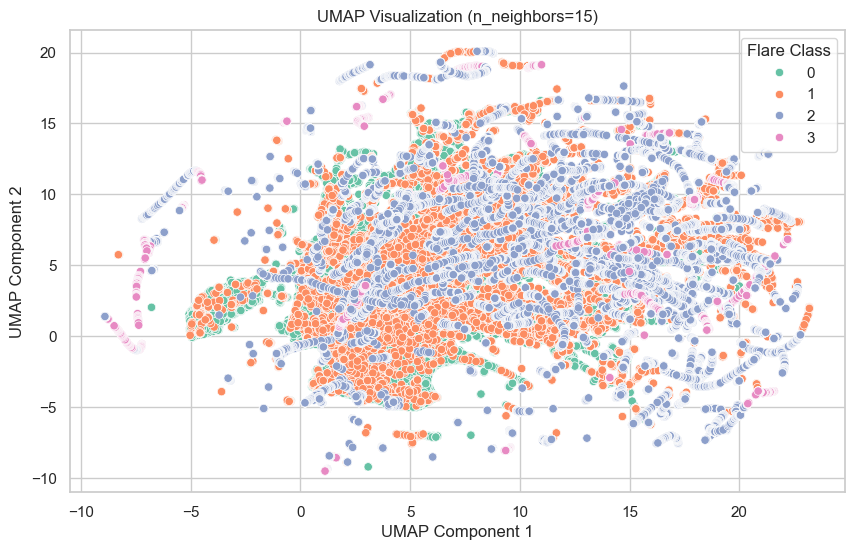

UMAP completed on 127875 samples


In [100]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [101]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [102]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train9=scaler.fit_transform(training_df[selected_features])
Y_train9=training_df['flare_numeric']

X_val9 = scaler.transform(validating_df[selected_features])
y_val9 = validating_df['flare_numeric']

X_test9 = scaler.transform(testing_df[selected_features])
y_test9 = testing_df['flare_numeric']

print("Training samples:", len(X_train9))
print("Validation samples:",len(X_val9))
print("Test samples:",len(X_test9))
print("Total samples:", str(len(X_train9) + len(X_val9) + len(X_test9)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


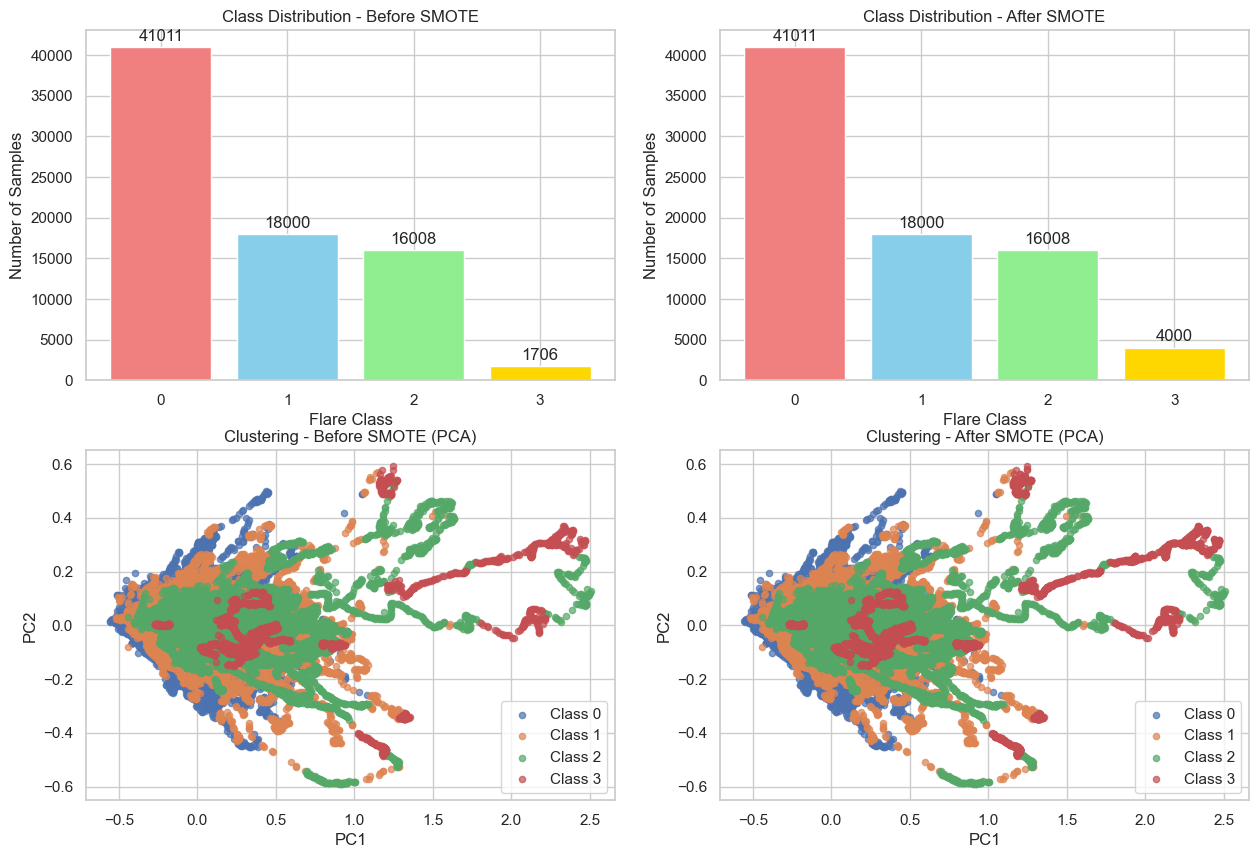


Total samples increased from 76725 to 79019


In [103]:
ss={3:4000}
X_train9, Y_train9, smote_model = apply_smote_balancing(df_filtered=training_df, selected_features=selected_features,target_col='flare_numeric',k_neighbors=3,random_state=RANDOM_STATE,sampling_strat=ss)

## Training

In [108]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train9), y=Y_train9)
class_weight_dict = dict(enumerate(class_weights))

svm_model9 = SVC(kernel='linear', random_state=42)

svm_model9.fit(X_train9, Y_train9)

y_train_pred9 = svm_model9.predict(X_train9)
y_test_pred9 = svm_model9.predict(X_test9)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [109]:
train_accuracy_9 = accuracy_score(Y_train9, y_train_pred9)
test_accuracy_9 = accuracy_score(y_test9, y_test_pred9)
test_precision_9 = precision_score(y_test9, y_test_pred9, average='weighted', zero_division=0)
test_recall_9 = recall_score(y_test9, y_test_pred9, average='weighted', zero_division=0)
test_f1_9 = f1_score(y_test9, y_test_pred9, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_9:.4f} ({train_accuracy_9*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_9:.4f} ({test_accuracy_9*100:.2f}%)")
print(f"PRECISION:         {test_precision_9:.4f}")
print(f"RECALL:            {test_recall_9:.4f}")
print(f"F1-SCORE:          {test_f1_9:.4f}")

TRAINING ACCURACY: 0.6447 (64.47%)
TEST ACCURACY:     0.5734 (57.34%)
PRECISION:         0.6204
RECALL:            0.5734
F1-SCORE:          0.5483


In [110]:
print(classification_report(y_test9, y_test_pred9, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.75      0.88      0.81     13670
     C-Class       0.43      0.05      0.09      6000
     M-Class       0.57      0.36      0.44      5336
     X-Class       0.07      0.68      0.13       569

    accuracy                           0.57     25575
   macro avg       0.45      0.49      0.37     25575
weighted avg       0.62      0.57      0.55     25575



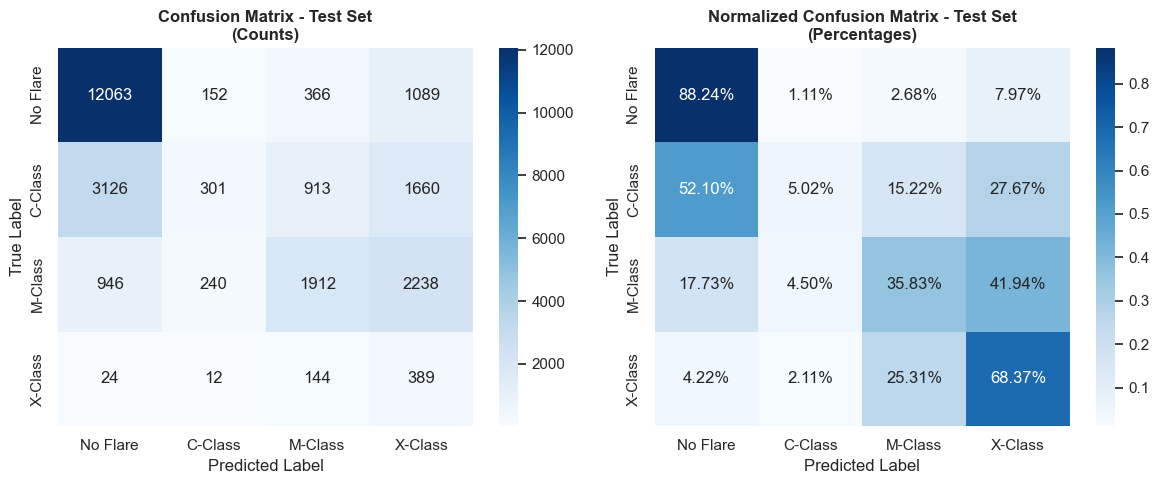

In [111]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test9, y_test_pred9)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 10
Smote self made sampling strat

kernel =rfb

Weights

C=0.1

In [21]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


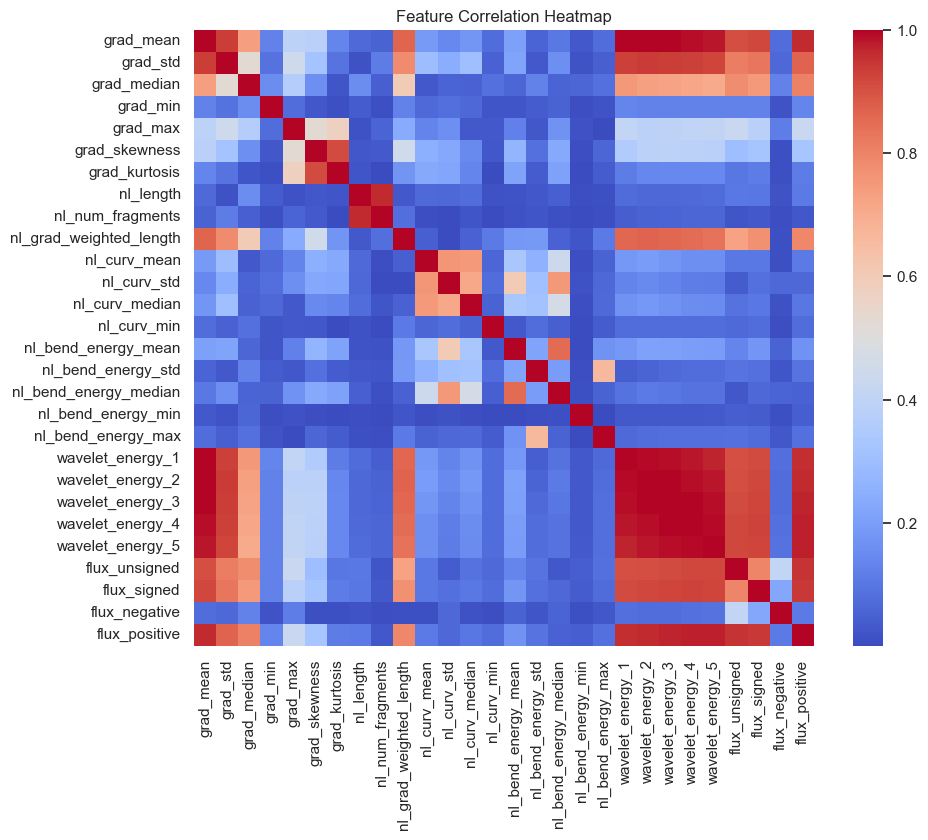

In [22]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

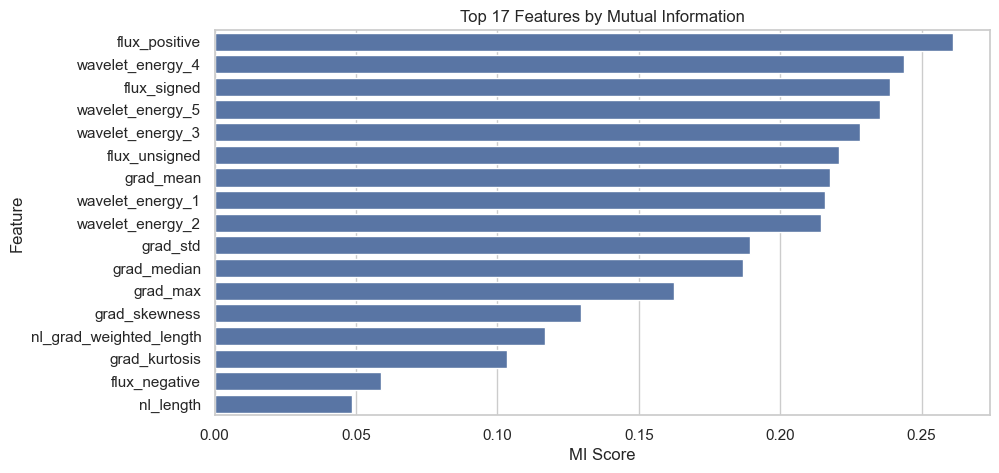

(127875, 18)

In [23]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


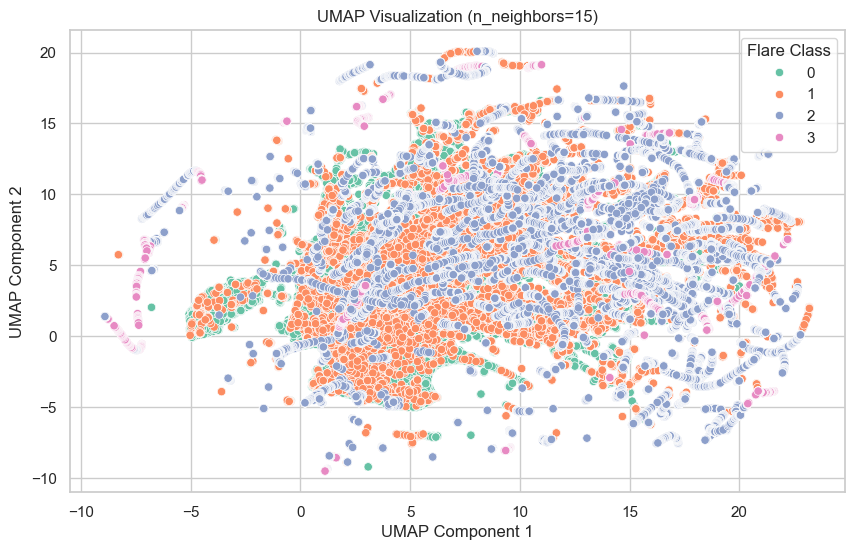

UMAP completed on 127875 samples


In [24]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [25]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [26]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train10=scaler.fit_transform(training_df[selected_features])
Y_train10=training_df['flare_numeric']

X_val10 = scaler.transform(validating_df[selected_features])
y_val10 = validating_df['flare_numeric']

X_test10 = scaler.transform(testing_df[selected_features])
y_test10 = testing_df['flare_numeric']

print("Training samples:", len(X_train10))
print("Validation samples:",len(X_val10))
print("Test samples:",len(X_test10))
print("Total samples:", str(len(X_train10) + len(X_val10) + len(X_test10)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


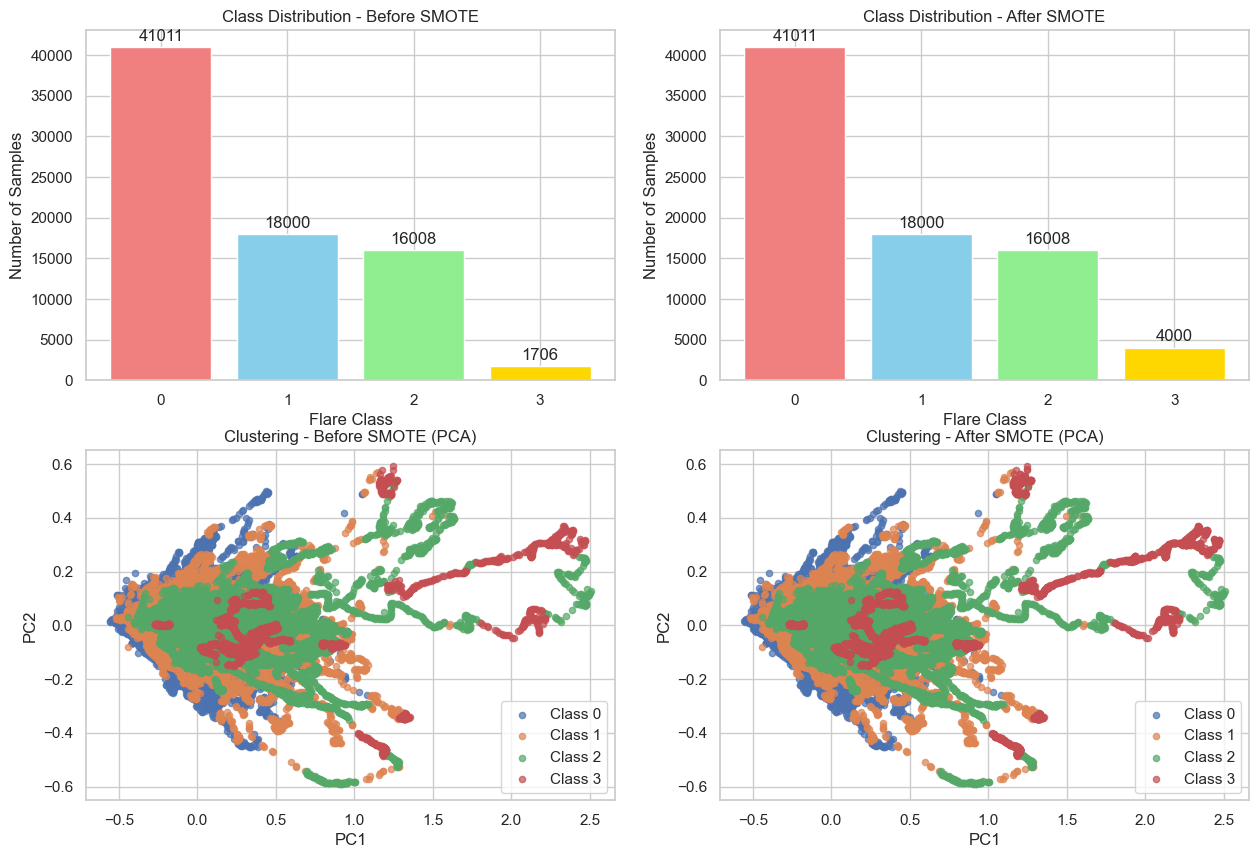


Total samples increased from 76725 to 79019


In [27]:
ss={3:4000}
X_train10, Y_train10, smote_model = apply_smote_balancing(df_filtered=training_df, selected_features=selected_features,target_col='flare_numeric',k_neighbors=3,random_state=RANDOM_STATE,sampling_strat=ss)

## Training

In [28]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train10), y=Y_train10)
class_weight_dict = dict(enumerate(class_weights))

svm_model10 = SVC(kernel='rbf',C=0.1, class_weight=class_weight_dict, random_state=42)

svm_model10.fit(X_train10, Y_train10)

y_train_pred10 = svm_model10.predict(X_train10)
y_test_pred10 = svm_model10.predict(X_test10)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [29]:
train_accuracy_10 = accuracy_score(Y_train10, y_train_pred10)
test_accuracy_10 = accuracy_score(y_test10, y_test_pred10)
test_precision_10 = precision_score(y_test10, y_test_pred10, average='weighted', zero_division=0)
test_recall_10 = recall_score(y_test10, y_test_pred10, average='weighted', zero_division=0)
test_f1_10 = f1_score(y_test10, y_test_pred10, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_10:.4f} ({train_accuracy_10*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_10:.4f} ({test_accuracy_10*100:.2f}%)")
print(f"PRECISION:         {test_precision_10:.4f}")
print(f"RECALL:            {test_recall_10:.4f}")
print(f"F1-SCORE:          {test_f1_10:.4f}")

TRAINING ACCURACY: 0.5984 (59.84%)
TEST ACCURACY:     0.5410 (54.10%)
PRECISION:         0.5662
RECALL:            0.5410
F1-SCORE:          0.3973


In [31]:
print(classification_report(y_test10, y_test_pred10, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.55      0.99      0.71     13670
     C-Class       0.39      0.05      0.08      6000
     M-Class       0.88      0.00      0.01      5336
     X-Class       0.00      0.00      0.00       569

    accuracy                           0.54     25575
   macro avg       0.45      0.26      0.20     25575
weighted avg       0.57      0.54      0.40     25575



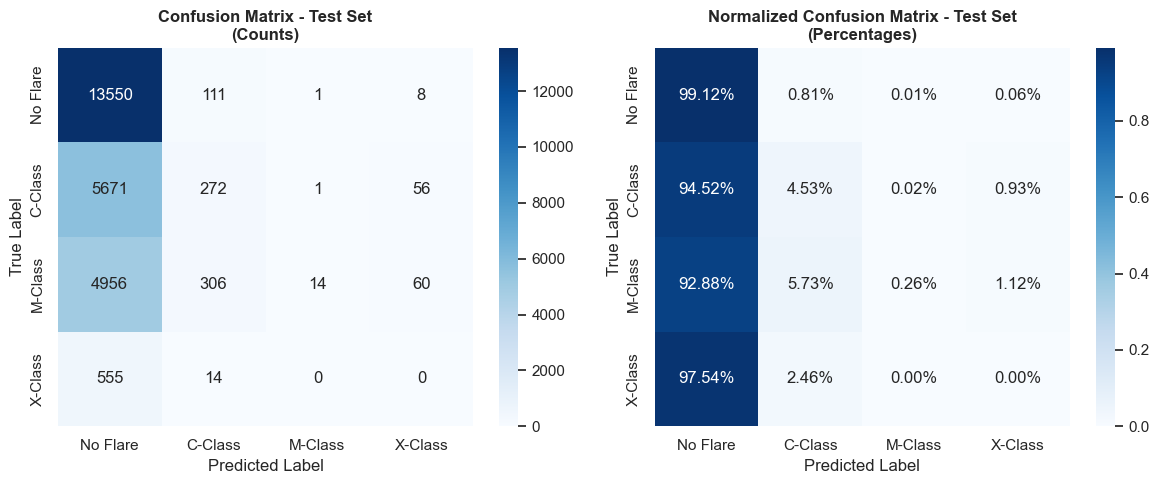

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test10, y_test_pred10)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Model 11

kernel =rfb

Weights

C=3

In [33]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Preproccessing

Low-variance features:


['nl_curv_max']

Highly correlated features:


['wavelet_energy_1',
 'wavelet_energy_2',
 'wavelet_energy_3',
 'wavelet_energy_4',
 'wavelet_energy_5',
 'flux_positive']

Original feature count: 29
Remaining feature count: 22


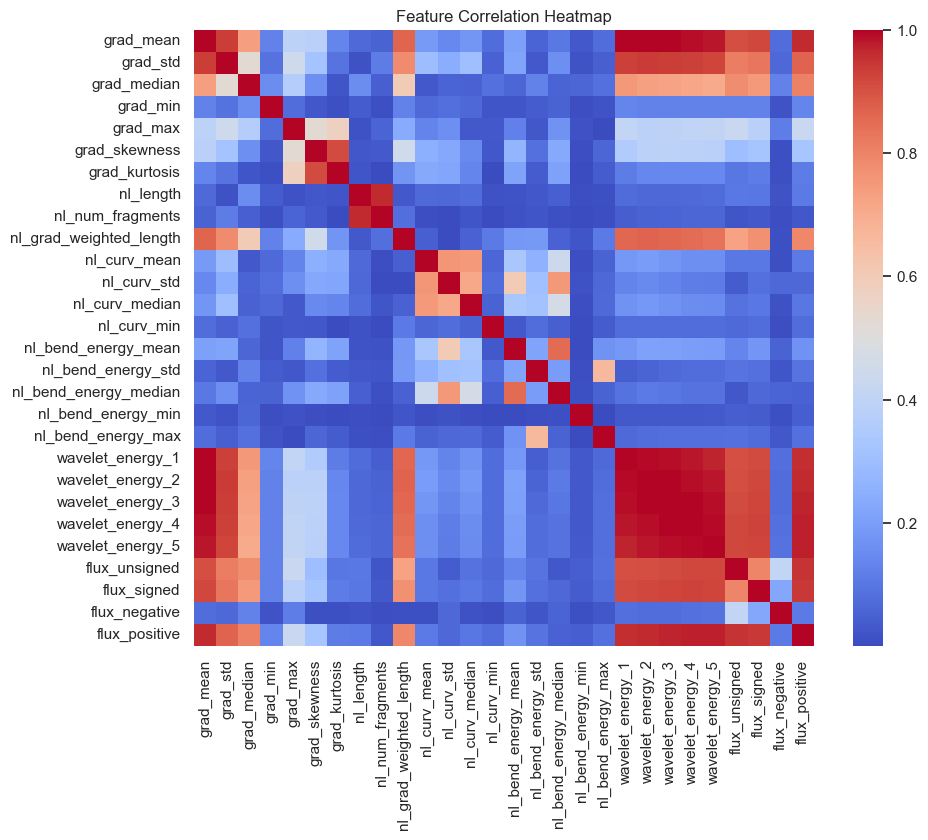

In [34]:
#Removing the features that have a low variance (Barely changing in all data points)
#Removing the features 
df_filtered, selected_features = removing_high_and_low(df,feature_cols)

Top features by MI:


['flux_positive',
 'wavelet_energy_4',
 'flux_signed',
 'wavelet_energy_5',
 'wavelet_energy_3',
 'flux_unsigned',
 'grad_mean',
 'wavelet_energy_1',
 'wavelet_energy_2',
 'grad_std',
 'grad_median',
 'grad_max',
 'grad_skewness',
 'nl_grad_weighted_length',
 'grad_kurtosis',
 'flux_negative',
 'nl_length']

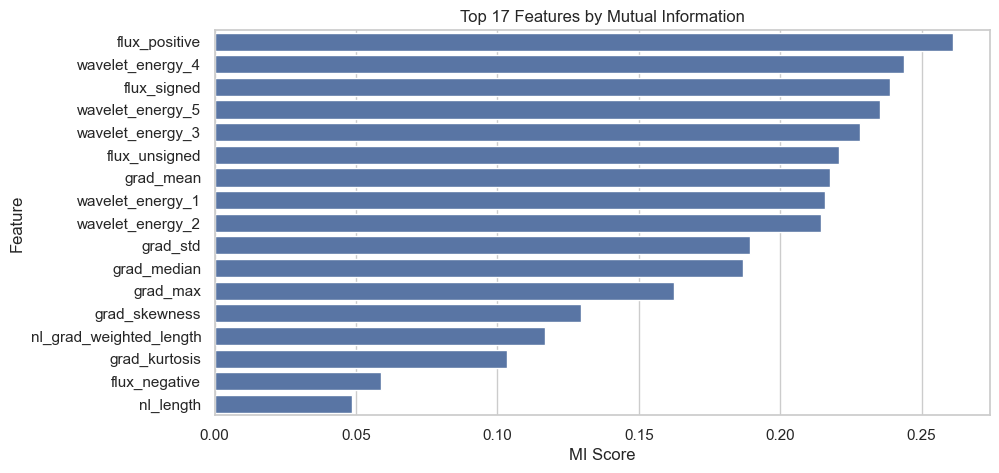

(127875, 18)

In [35]:
#
df_filtered,selected_features =Feature_MI_Choosing(df,feature_cols,17)
display(df_filtered.shape)

c:\Users\Asus\Desktop\University\Fall 2025\EECE 490\Codes\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


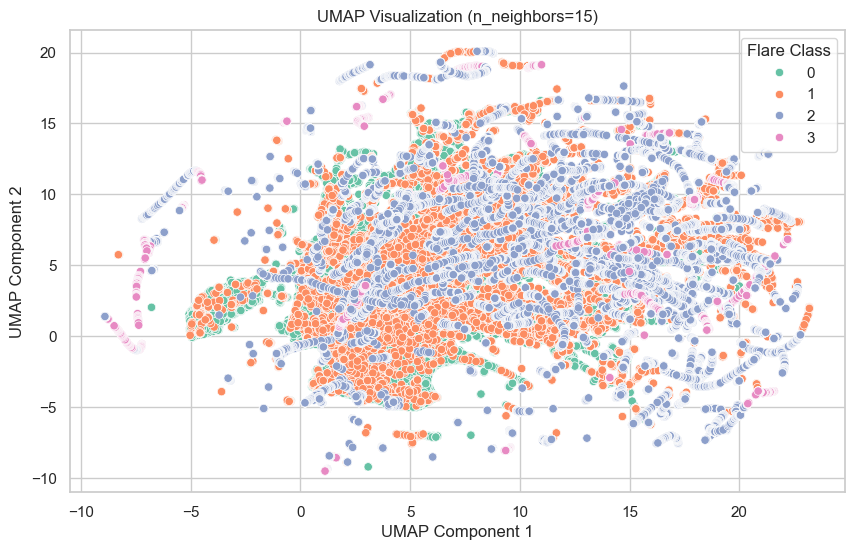

UMAP completed on 127875 samples


In [36]:
umap_df, umap_model = perform_umap_analysis(df_filtered=df_filtered,selected_features=selected_features,n_neighbors=15,min_dist=0.1)

In [37]:
#Splitting the data into training, validating and testing datasets while making sure that each dataset has all type of classes
train_val_df, testing_df = train_test_split(df_filtered, test_size=0.2,  random_state=42,stratify=df_filtered['flare_numeric'])
training_df, validating_df = train_test_split(train_val_df, test_size=0.25,random_state=42,stratify=train_val_df['flare_numeric'])

In [38]:
#Standarizing all feature colmns and splitting the feature columns from the labels
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train11=scaler.fit_transform(training_df[selected_features])
Y_train11=training_df['flare_numeric']

X_val11 = scaler.transform(validating_df[selected_features])
y_val11 = validating_df['flare_numeric']

X_test11 = scaler.transform(testing_df[selected_features])
y_test11 = testing_df['flare_numeric']

print("Training samples:", len(X_train11))
print("Validation samples:",len(X_val11))
print("Test samples:",len(X_test11))
print("Total samples:", str(len(X_train11) + len(X_val11) + len(X_test11)))

Training samples: 76725
Validation samples: 25575
Test samples: 25575
Total samples: 127875


## Training

In [39]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train11), y=Y_train11)
class_weight_dict = dict(enumerate(class_weights))

svm_model11 = SVC(kernel='rbf',C=3,probability=True, class_weight=class_weight_dict, random_state=42)

svm_model11.fit(X_train11, Y_train11)

y_train_pred11 = svm_model11.predict(X_train11)
y_test_pred11 = svm_model11.predict(X_test11)

In [40]:
train_accuracy_11 = accuracy_score(Y_train11, y_train_pred11)
test_accuracy_11 = accuracy_score(y_test11, y_test_pred11)
test_precision_11 = precision_score(y_test11, y_test_pred11, average='weighted', zero_division=0)
test_recall_11 = recall_score(y_test11, y_test_pred11, average='weighted', zero_division=0)
test_f1_11 = f1_score(y_test11, y_test_pred11, average='weighted', zero_division=0)

print(f"TRAINING ACCURACY: {train_accuracy_11:.4f} ({train_accuracy_11*100:.2f}%)")
print(f"TEST ACCURACY:     {test_accuracy_11:.4f} ({test_accuracy_11*100:.2f}%)")
print(f"PRECISION:         {test_precision_11:.4f}")
print(f"RECALL:            {test_recall_11:.4f}")
print(f"F1-SCORE:          {test_f1_11:.4f}")

TRAINING ACCURACY: 0.6887 (68.87%)
TEST ACCURACY:     0.6840 (68.40%)
PRECISION:         0.6998
RECALL:            0.6840
F1-SCORE:          0.6886


In [41]:
print(classification_report(y_test11, y_test_pred11, target_names=['No Flare', 'C-Class', 'M-Class', 'X-Class'], zero_division=0))

              precision    recall  f1-score   support

    No Flare       0.84      0.76      0.79     13670
     C-Class       0.44      0.46      0.45      6000
     M-Class       0.66      0.72      0.69      5336
     X-Class       0.48      0.97      0.64       569

    accuracy                           0.68     25575
   macro avg       0.60      0.73      0.64     25575
weighted avg       0.70      0.68      0.69     25575



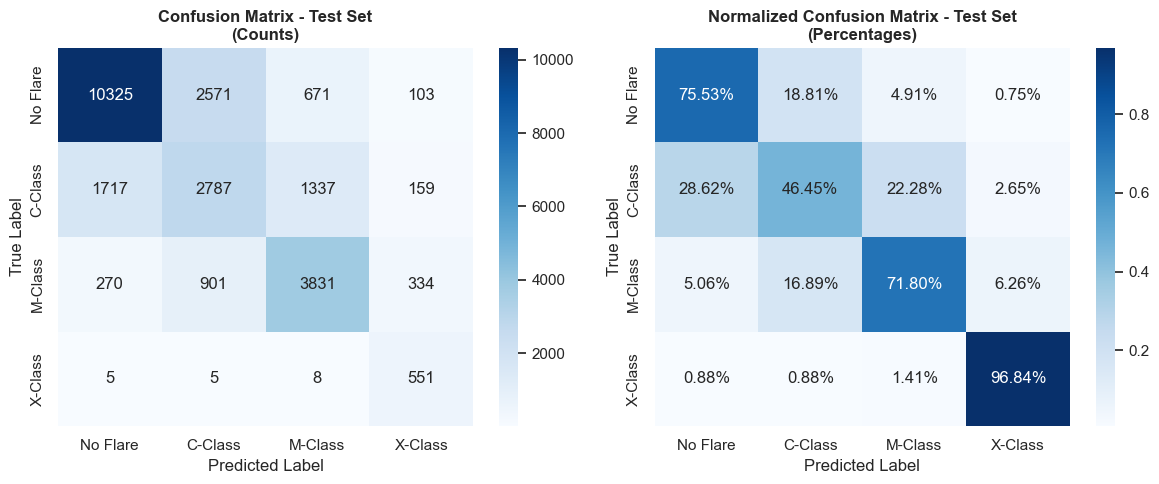

In [42]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test11, y_test_pred11)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Confusion Matrix - Test Set\n(Counts)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'],
            yticklabels=['No Flare', 'C-Class', 'M-Class', 'X-Class'])
plt.title('Normalized Confusion Matrix - Test Set\n(Percentages)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()